<h1 style="text-align: center; font-weight: bold;"><u>Analyse exploratoire</u></h1>

<h2 style="font-weight: bold;"><u>Import et chargement des données</u></h2>

In [45]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"

# Importation des bibliothèques pandas, numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import mlflow
import mlflow.sklearn
import joblib
import optuna
import gensim
import mlflow.tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tempfile


from collections import defaultdict, Counter  # Import de defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from mlflow.tracking import MlflowClient
from IPython.display import display, HTML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizerFast, TFBertForSequenceClassification, AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, TFTrainingArguments, TFAutoModel
from datasets import Dataset
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Model

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

from mesFonctions import (
    preprocess_text,
    illustrate_preprocessing
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<b class="term">Context:</b> 
<br>
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

<b class="term">Content:</b>
<br>
It contains the following 6 fields:
<ul>
    <li>target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)</li>
    <li>ids: The id of the tweet ( 2087)</li>
    <li>date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)</li>
    <li>flag: The query (lyx). If there is no query, then this value is NO_QUERY.</li>
    <li>user: the user that tweeted (robotickilldozr)</li>
    <li>text: the text of the tweet (Lyx is cool)</li>
</ul>

In [2]:
# Définir les noms de colonnes selon la documentation du dataset
column_names = [
    "target",   # 0 = negative, 2 = neutral, 4 = positive
    "ids",      # Tweet ID
    "date",     # Date du tweet
    "flag",     # Query (ou NO_QUERY)
    "user",     # Utilisateur
    "text"      # Contenu du tweet
]

# Lire le CSV avec les bons paramètres
tweets = pd.read_csv(
    "data/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",      # Important : évite les erreurs d'encodage
    names=column_names,      # On fixe les noms de colonnes
    header=None              # Car le fichier n’a pas de ligne d’en-tête
)

In [3]:
tweets.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# 3. Infos générales
print("Shape:", tweets.shape)
print("\nColonnes:", tweets.columns.tolist())
tweets.info()
tweets.describe(include='all')

Shape: (1600000, 6)

Colonnes: ['target', 'ids', 'date', 'flag', 'user', 'text']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,target,ids,date,flag,user,text
count,1.600000e+06,1.600000e+06,1600000,1600000,1600000,1600000
unique,NaN,NaN,774363,1,659775,1581466
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1600000,549,210
mean,2.000000e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935761e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467810e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,2.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


In [5]:
# 4. Valeurs manquantes et doublons
print("Valeurs manquantes:\n", tweets.isnull().sum())
print("Doublons:", tweets.duplicated().sum())

Valeurs manquantes:
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
Doublons: 0


<h2 style="font-weight: bold;"><u>Tweets</u></h2>

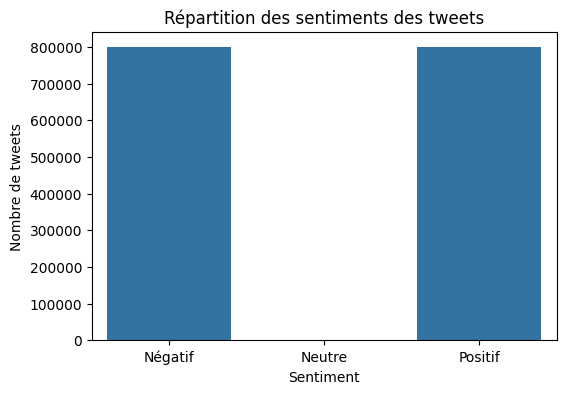

In [6]:
# Associe les labels numériques à des étiquettes lisibles
sentiment_map = {
    0: "Négatif",
    2: "Neutre",
    4: "Positif"
}

tweets["sentiment"] = tweets["target"].map(sentiment_map)

plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=tweets, order=["Négatif", "Neutre", "Positif"])
plt.title("Répartition des sentiments des tweets")
plt.ylabel("Nombre de tweets")
plt.xlabel("Sentiment")
plt.show()


In [7]:
# Affiche uniquement les tweets négatifs (0), neutres et positifs (4)
print("Tweets négatifs (0):", (tweets["target"] == 0).sum())
print("Tweets neutres (2):", (tweets["target"] == 2).sum())
print("Tweets positifs (4):", (tweets["target"] == 4).sum())

Tweets négatifs (0): 800000
Tweets neutres (2): 0
Tweets positifs (4): 800000


In [8]:
# Longueur en nombre de mots
tweets["word_count"] = tweets["text"].apply(lambda x: len(str(x).split()))

# Longueur en nombre de caractères
tweets["char_count"] = tweets["text"].apply(lambda x: len(str(x)))


In [9]:
# Statistiques globales
print("Statistiques sur la longueur en mots :")
print(tweets["word_count"].describe())

print("\nStatistiques sur la longueur en caractères :")
print(tweets["char_count"].describe())


Statistiques sur la longueur en mots :
count    1.600000e+06
mean     1.317615e+01
std      6.957978e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: word_count, dtype: float64

Statistiques sur la longueur en caractères :
count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: char_count, dtype: float64


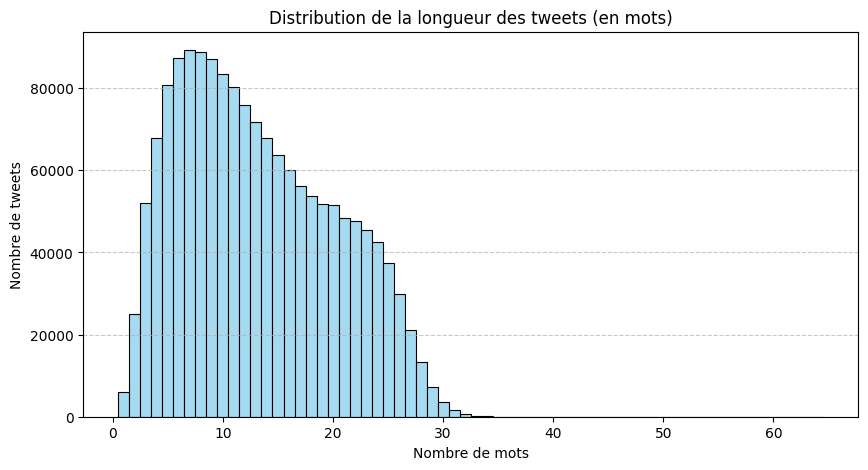

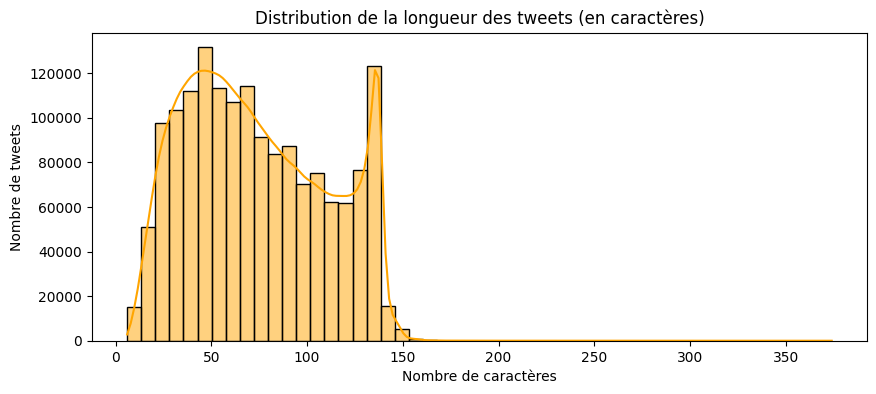

In [10]:
# Histogramme des longueurs en mots
plt.figure(figsize=(10, 5))
sns.histplot(data=tweets, x="word_count", bins=range(1, 65), discrete=True, color="skyblue")
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Histogramme des longueurs en caractères
plt.figure(figsize=(10, 4))
sns.histplot(tweets["char_count"], bins=50, kde=True, color='orange')
plt.title("Distribution de la longueur des tweets (en caractères)")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de tweets")
plt.show()


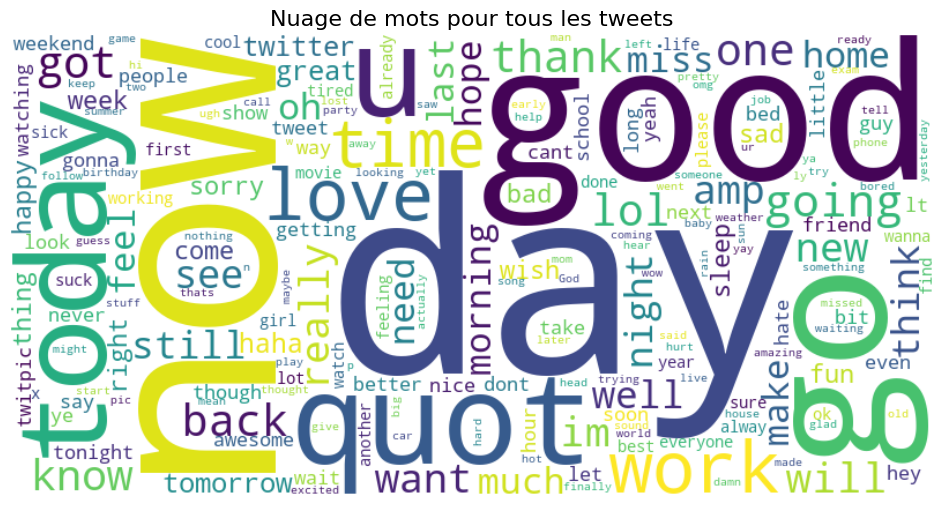

In [11]:
# Concaténer tous les textes en une seule chaîne
all_text = " ".join(str(tweet) for tweet in tweets["text"])

# Créer le WordCloud
wordcloud = WordCloud(width=800, height=400,
                      background_color="white",
                      collocations=False).generate(all_text)

# Afficher
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots pour tous les tweets", fontsize=16)
plt.show()

<h2 style="font-weight: bold;"><u>Nettoyage (suppression URLs, mentions, hashtags)Tokenisation, Suppression des stopwords, Lemmatisation, Reconstruction du texte nettoyé

WordCloud à partir des textes nettoyés
</u></h2>

In [12]:
# Appliquer le nettoyage
tweets["clean_text"] = tweets["text"].astype(str).apply(preprocess_text)

In [13]:
# --- 1. Mise en minuscules ---
# Exemple: tweet avec des majuscules
example_lower = tweets[tweets['text'].str.contains(r'[A-Z]', regex=True)].sample(1, random_state=1)['text'].iloc[0]
processed_lower = illustrate_preprocessing(example_lower, "Mise en minuscules")

# --- 2. Suppression des URLs ---
# Recherche d'un tweet contenant une URL
example_url = tweets[tweets['text'].str.contains(r'http\S+|www\S+|https\S+', regex=True)].sample(1, random_state=2)['text'].iloc[0]
processed_url = illustrate_preprocessing(example_url, "Suppression des URLs")

# --- 3. Suppression mentions et hashtags ---
# Recherche d'un tweet contenant une mention ou un hashtag
example_mention_hashtag = tweets[tweets['text'].str.contains(r'@\w+|#\w+', regex=True)].sample(1, random_state=3)['text'].iloc[0]
processed_mention_hashtag = illustrate_preprocessing(example_mention_hashtag, "Suppression mentions et hashtags")

# --- 4. Suppression ponctuation et chiffres ---
# Recherche d'un tweet avec ponctuation et/ou chiffres
example_punctuation_digits = tweets[tweets['text'].str.contains(r'[^a-zA-Z\s]', regex=True)].sample(1, random_state=4)['text'].iloc[0]
processed_punctuation_digits = illustrate_preprocessing(example_punctuation_digits, "Suppression ponctuation et chiffres")

# --- 5. Suppression des mots composés d’une seule lettre répétée ---
# Pour cet exemple, nous allons créer un tweet artificiel car il est rare d'en trouver un parfait dans les données brutes.
example_repeated_char = "Noooooooo, this is so baaaaaad. Hahaha, I feel terrible today."
processed_repeated_char = illustrate_preprocessing(example_repeated_char, "Suppression des mots répétés")

# --- 6. Tokenisation, Lemmatisation et suppression des Stopwords ---
# Nous allons prendre un tweet "relativement" complexe pour montrer l'effet combiné.
example_full_process = tweets.sample(1, random_state=5)['text'].iloc[0]
processed_full = illustrate_preprocessing(example_full_process, "Tokenisation, Lemmatisation et Stopwords")


--- Étape: Mise en minuscules ---
Original: 'says Good Afternoon!  Karma Down (tears) http://plurk.com/p/xbznf'
Nettoyé:  'says good afternoon!  karma down (tears) http://plurk.com/p/xbznf'

--- Étape: Suppression des URLs ---
Original: '@guitarinjustin http://bit.ly/MWX6x   you will love this video '
Nettoyé:  '@guitarinjustin    you will love this video '

--- Étape: Suppression mentions et hashtags ---
Original: '@Wardere ugh, ur so lucky, i have 3 more exams left '
Nettoyé:  ' ugh, ur so lucky, i have 3 more exams left '

--- Étape: Suppression ponctuation et chiffres ---
Original: '@Fred0828 No way, Fred! You rock!!  Way beyond thoughtful and kind!!!!!!!!  No worries!!!!!!!!!!!!!!! '
Nettoyé:  'red o way red ou rock  ay beyond thoughtful and kind  o worries '

--- Étape: Suppression des mots répétés ---
Original: 'Noooooooo, this is so baaaaaad. Hahaha, I feel terrible today.'
Nettoyé:  'Noooooooo, this is so baaaaaad. Hahaha, I feel terrible today.'

--- Étape: Tokenisation, Lem

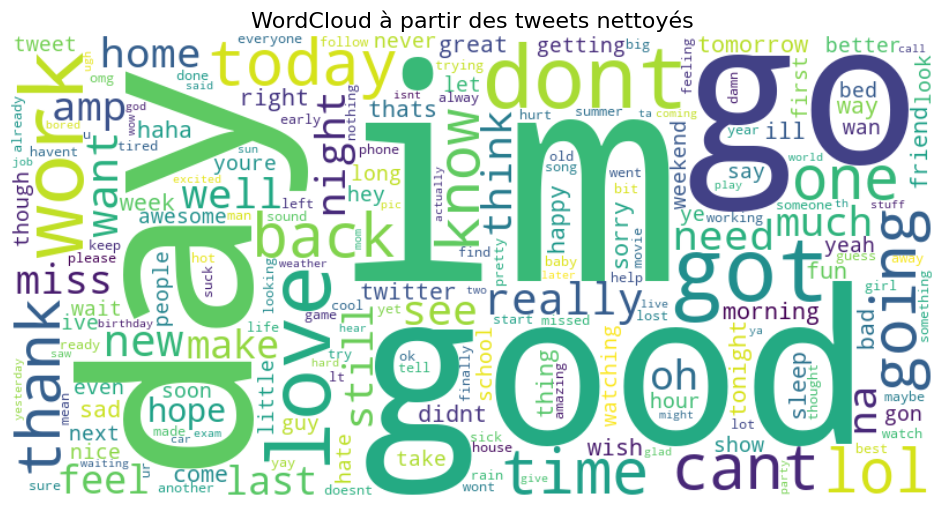

In [14]:
# Concaténer tous les textes nettoyés
all_cleaned_text = " ".join(tweets["clean_text"])

# Générer le WordCloud
wordcloud_clean = WordCloud(width=800, height=400,
                            background_color="white",
                            stopwords=None,  # Déjà nettoyé
                            collocations=False).generate(all_cleaned_text)

# Afficher
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_clean, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud à partir des tweets nettoyés", fontsize=16)
plt.show()


<h2 style="font-weight: bold;"><u>WordCloud des Tweets Négatifs</u></h2>

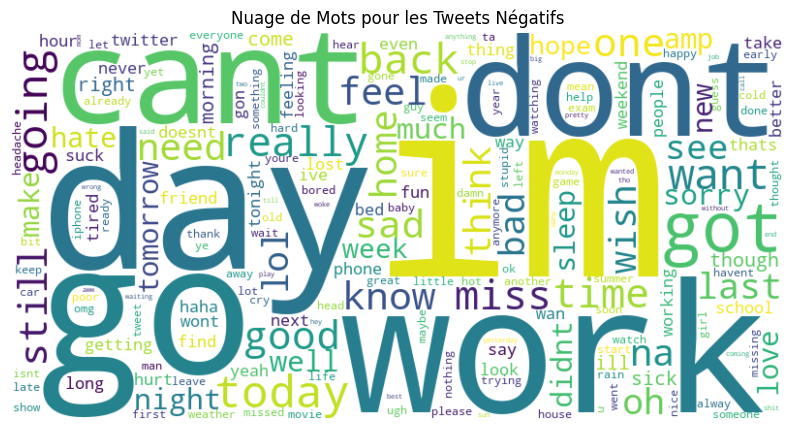

In [15]:
tweets["processed_text"] = tweets["text"].apply(preprocess_text)


# --- WordCloud des Tweets Négatifs ---
negative_tweets = tweets[tweets["target"] == 0]["processed_text"]
negative_text = " ".join(negative_tweets.dropna()) # Joindre tous les textes, en gérant les NaN

if negative_text:
    wordcloud_neg = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False # Éviter les phrases et se concentrer sur les mots individuels
    ).generate(negative_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Nuage de Mots pour les Tweets Négatifs')
    plt.axis('off')
    plt.show()
else:
    print("Aucun texte à analyser pour les tweets négatifs.")

<h2 style="font-weight: bold;"><u>WordCloud des Tweets Positifs</u></h2>

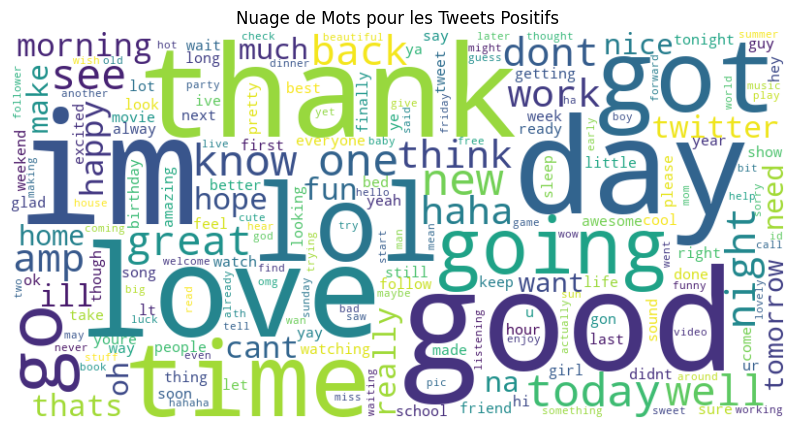

In [16]:
# --- WordCloud des Tweets Positifs ---
positive_tweets = tweets[tweets["target"] == 4]["processed_text"]
positive_text = " ".join(positive_tweets.dropna()) # Joindre tous les textes, en gérant les NaN

if positive_text:
    wordcloud_pos = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False
    ).generate(positive_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Nuage de Mots pour les Tweets Positifs')
    plt.axis('off')
    plt.show()
else:
    print("Aucun texte à analyser pour les tweets positifs.")

<h2 style="font-weight: bold;"><u>Utilisateur</u></h2>

In [17]:
# Étape 1 : Moyenne de tweets par utilisateur
tweets_per_user = tweets["user"].value_counts()
average_tweets_per_user = tweets_per_user.mean()

print(f"Moyenne de tweets par utilisateur : {average_tweets_per_user:.2f}")


Moyenne de tweets par utilisateur : 2.43


In [18]:
# Étape 2 : Nombre de tweets par utilisateur + période
# A.Convertir la colonne date au format datetime
tweets["date"] = pd.to_datetime(tweets["date"], errors="coerce")


C:\Users\david\AppData\Local\Temp\ipykernel_74880\3537526045.py:3: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets["date"] = pd.to_datetime(tweets["date"], errors="coerce")


In [19]:
# B.Compter les tweets par utilisateur
user_tweet_counts = tweets.groupby("user").agg(
    tweet_count=("text", "count"),
    first_tweet=("date", "min"),
    last_tweet=("date", "max")
).sort_values(by="tweet_count", ascending=False)

print(user_tweet_counts.head(10))  # top 10 utilisateurs les plus actifs


                 tweet_count         first_tweet          last_tweet
user                                                                
lost_dog                 549 2009-05-01 22:54:02 2009-06-25 10:11:34
webwoke                  345 2009-06-05 14:12:05 2009-06-07 21:08:10
tweetpet                 310 2009-04-17 22:00:01 2009-05-02 06:01:03
SallytheShizzle          281 2009-05-22 00:26:38 2009-06-25 06:44:30
VioletsCRUK              279 2009-04-07 01:14:14 2009-06-20 16:20:04
mcraddictal              276 2009-04-18 07:46:22 2009-06-07 00:18:40
tsarnick                 248 2009-04-06 22:52:56 2009-05-31 01:38:01
what_bugs_u              246 2009-05-30 20:18:46 2009-06-07 20:37:30
Karen230683              238 2009-04-07 00:43:43 2009-06-21 09:39:08
DarkPiano                236 2009-04-07 04:19:32 2009-06-07 20:16:52


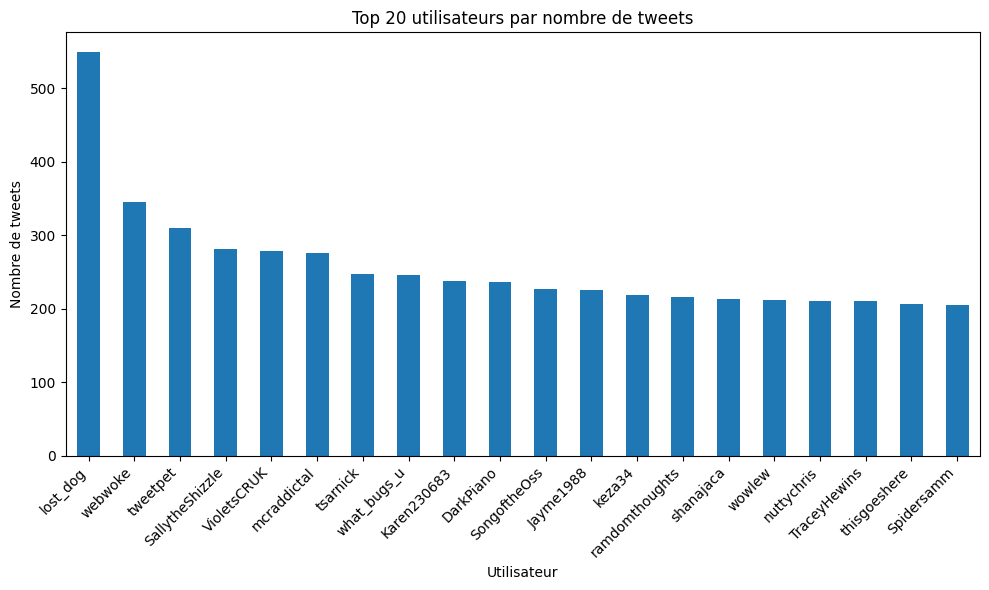

In [20]:
# C.Afficher les 20 utilisateurs les plus actifs
top_users = user_tweet_counts.head(20)

plt.figure(figsize=(10, 6))
top_users["tweet_count"].plot(kind="bar")
plt.title("Top 20 utilisateurs par nombre de tweets")
plt.ylabel("Nombre de tweets")
plt.xlabel("Utilisateur")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [21]:
# Étape 3 : Grouper les tweets proches dans le temps
# A. Grouper les tweets par période (ex. jour, semaine, mois)
# Grouper par jour
tweets_by_day = tweets.set_index("date").resample("D").size()

# Grouper par semaine
tweets_by_week = tweets.set_index("date").resample("W").size()


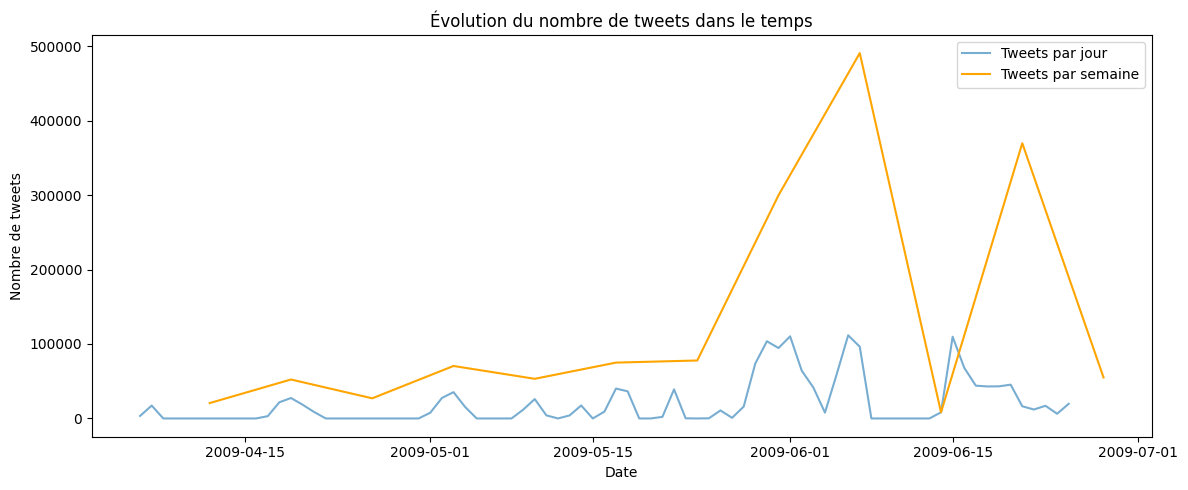

In [22]:
# B. Graphe des tweets dans le temps

plt.figure(figsize=(12, 5))

plt.plot(tweets_by_day.index, tweets_by_day.values, label="Tweets par jour", alpha=0.6)
plt.plot(tweets_by_week.index, tweets_by_week.values, label="Tweets par semaine", color='orange')

plt.title("Évolution du nombre de tweets dans le temps")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_74880\3721631004.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets["date"] = pd.to_datetime(tweets["date"], errors='coerce')


❌ Il manque des tweets pour 33 jours.
Dates sans tweet :
- 2009-04-08
- 2009-04-09
- 2009-04-10
- 2009-04-11
- 2009-04-12
- 2009-04-13
- 2009-04-14
- 2009-04-15
- 2009-04-16
- 2009-04-22
- 2009-04-23
- 2009-04-24
- 2009-04-25
- 2009-04-26
- 2009-04-27
- 2009-04-28
- 2009-04-29
- 2009-04-30
- 2009-05-05
- 2009-05-06
- 2009-05-07
- 2009-05-08
- 2009-05-12
- 2009-05-15
- 2009-05-19
- 2009-05-20
- 2009-05-24
- 2009-06-08
- 2009-06-09
- 2009-06-10
- 2009-06-11
- 2009-06-12
- 2009-06-13


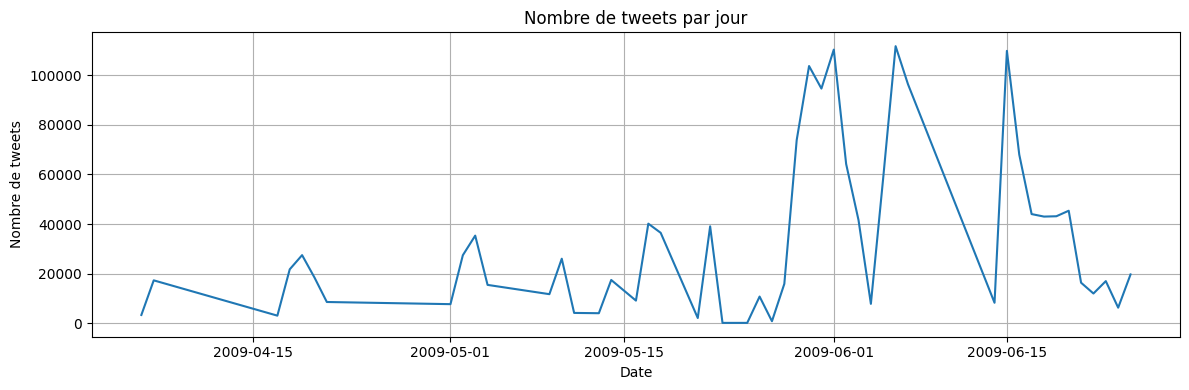

In [40]:
# 1. Convertir la colonne "date" au format datetime
tweets["date"] = pd.to_datetime(tweets["date"], errors='coerce')

# 2. Extraire uniquement la date (sans l'heure)
tweets["date_only"] = tweets["date"].dt.date

# 3. Grouper par date et compter le nombre de tweets
tweets_per_day = tweets.groupby("date_only").size()

# 4. Créer une plage de dates complète du min au max
full_date_range = pd.date_range(start=tweets["date_only"].min(), end=tweets["date_only"].max()).date

# 5. Identifier les dates manquantes (sans tweet)
missing_dates = sorted(set(full_date_range) - set(tweets_per_day.index))

# 6. Afficher le résultat
if not missing_dates:
    print("✅ Il y a au moins un tweet pour chaque jour de la période.")
else:
    print(f"❌ Il manque des tweets pour {len(missing_dates)} jours.")
    print("Dates sans tweet :")
    for d in missing_dates:
        print("-", d)

# 7. (Optionnel) Visualisation du nombre de tweets par jour
tweets_per_day.plot(figsize=(12, 4), title="Nombre de tweets par jour")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# --- Filtrer pour les sentiments 0 et 4 (négatif et positif) ---
# Votre modèle travaille avec 0 et 4, donc nous allons nous concentrer sur ceux-ci.
# Si vous souhaitez inclure les neutres (2), il faudrait adapter les calculs de proportion.
tweets = tweets[tweets["target"].isin([0, 4])].copy()

# --- Mapper les cibles binaires : 0 (négatif), 1 (positif) ---
tweets["sentiment_binary"] = tweets["target"].map({0: 0, 4: 1})

Nettoyage des tweets...
Nettoyage terminé. Supprimé 0 tweets vides.
Nombre de tweets restants pour l'analyse : 1591690
Calcul des fréquences de mots par sentiment...

--- 20 Mots les plus positifs (apparaissent presque exclusivement dans les tweets positifs) ---
                  word  positive_ratio  total_count
266000      timefollow        1.000000          155
265999       laughhave        1.000000          155
265328  emailunlimited        1.000000          100
159228        fuzzball        0.990000          100
184646        dividend        0.988235           85
97863      shareholder        0.976471           85
1512        recommends        0.972727          110
16533            atcha        0.965517           87
83176      endorsement        0.963636           55
121371       timestamp        0.958333           72
86449        gratitude        0.951613           62
144388      pleasantly        0.942308           52
11722          honored        0.941176          170
57746    

C:\Users\david\AppData\Local\Temp\ipykernel_74880\3693551259.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='positive_ratio', y='word', data=most_positive_words, palette='viridis')
C:\Users\david\AppData\Local\Temp\ipykernel_74880\3693551259.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='positive_ratio', y='word', data=most_negative_words, palette='magma')


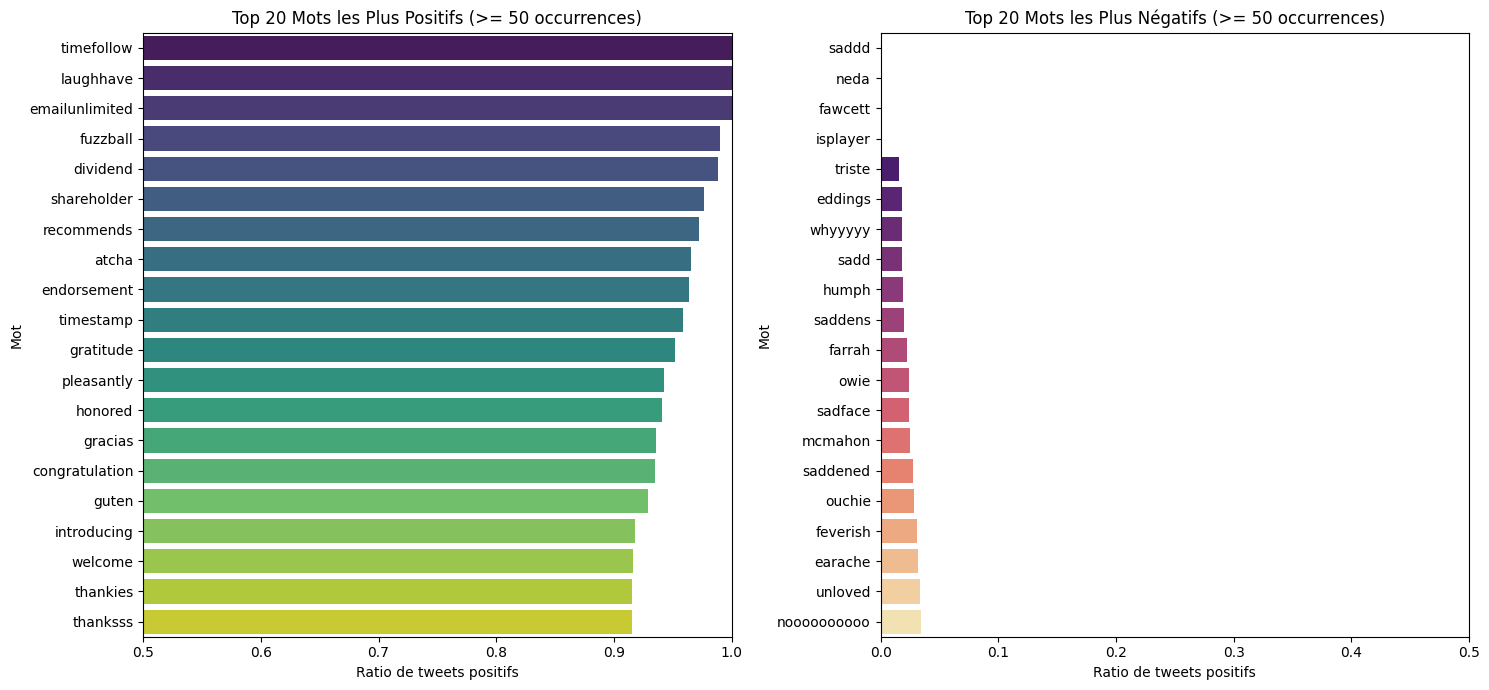


Analyse par mot terminée.


In [48]:
# --- Appliquer le nettoyage (référence à votre code précédent) ---
print("Nettoyage des tweets...")
tweets["clean_text"] = tweets["text"].astype(str).apply(preprocess_text)
initial_rows = len(tweets)
tweets.replace('', np.nan, inplace=True)
tweets.dropna(subset=['clean_text'], inplace=True)
print(f"Nettoyage terminé. Supprimé {initial_rows - len(tweets)} tweets vides.")
print(f"Nombre de tweets restants pour l'analyse : {len(tweets)}")


# --- Code pour l'analyse de sentiment par mot ---

# Tokeniser tous les tweets et compter les occurrences par sentiment
word_sentiment_counts = defaultdict(lambda: {'positive': 0, 'negative': 0, 'total': 0})

print("Calcul des fréquences de mots par sentiment...")
for index, row in tweets.iterrows():
    sentiment = row['sentiment_binary'] # 0 pour négatif, 1 pour positif
    words = row['clean_text'].split() # Les mots nettoyés sont déjà tokenisés et rejoins par un espace

    for word in words:
        word_sentiment_counts[word]['total'] += 1
        if sentiment == 1:
            word_sentiment_counts[word]['positive'] += 1
        else: # sentiment == 0
            word_sentiment_counts[word]['negative'] += 1

# Calculer le ratio de sentiment pour chaque mot
word_polarity = {}
for word, counts in word_sentiment_counts.items():
    if counts['total'] > 0:
        word_polarity[word] = counts['positive'] / counts['total']

# Convertir en DataFrame pour une meilleure manipulation et visualisation
word_polarity_df = pd.DataFrame([
    {'word': word, 'positive_ratio': ratio, 'total_count': word_sentiment_counts[word]['total']}
    for word, ratio in word_polarity.items()
])

# Visualiser les mots les plus polarisés
min_occurrences = 50
filtered_word_polarity_df = word_polarity_df[word_polarity_df['total_count'] >= min_occurrences].copy()

# Trier par ratio positif pour voir les mots les plus positifs
most_positive_words = filtered_word_polarity_df.sort_values(by='positive_ratio', ascending=False).head(20)
print("\n--- 20 Mots les plus positifs (apparaissent presque exclusivement dans les tweets positifs) ---")
print(most_positive_words)

# Trier par ratio positif pour voir les mots les plus négatifs
most_negative_words = filtered_word_polarity_df.sort_values(by='positive_ratio', ascending=True).head(20)
print("\n--- 20 Mots les plus négatifs (apparaissent presque exclusivement dans les tweets négatifs) ---")
print(most_negative_words)

# Visualisation
plt.figure(figsize=(15, 7))

# Plot des mots les plus positifs
plt.subplot(1, 2, 1)
sns.barplot(x='positive_ratio', y='word', data=most_positive_words, palette='viridis')
plt.title(f'Top {len(most_positive_words)} Mots les Plus Positifs (>= {min_occurrences} occurrences)')
plt.xlabel('Ratio de tweets positifs')
plt.ylabel('Mot')
plt.xlim(0.5, 1.0)

# Plot des mots les plus négatifs
plt.subplot(1, 2, 2)
sns.barplot(x='positive_ratio', y='word', data=most_negative_words, palette='magma')
plt.title(f'Top {len(most_negative_words)} Mots les Plus Négatifs (>= {min_occurrences} occurrences)')
plt.xlabel('Ratio de tweets positifs')
plt.ylabel('Mot')
plt.xlim(0.0, 0.5)

plt.tight_layout()
plt.show()

print("\nAnalyse par mot terminée.")


--- Résumé du sentiment par utilisateur (Top 10 utilisateurs) ---
                   user  total_tweets  positive_tweets  negative_tweets  \
472839         lost_dog           549                0              549   
639506          webwoke           345               81              264   
628471         tweetpet           310                0              310   
194652  SallytheShizzle           281               98              183   
232431      VioletsCRUK           279              218               61   
490950      mcraddictal           265               62              203   
640530      what_bugs_u           246              246                0   
627310         tsarnick           246              210               36   
112528      Karen230683           235              119              116   
54741         DarkPiano           235              230                5   

        positive_ratio  negative_ratio  sentiment_score_avg  
472839        0.000000        1.000000       

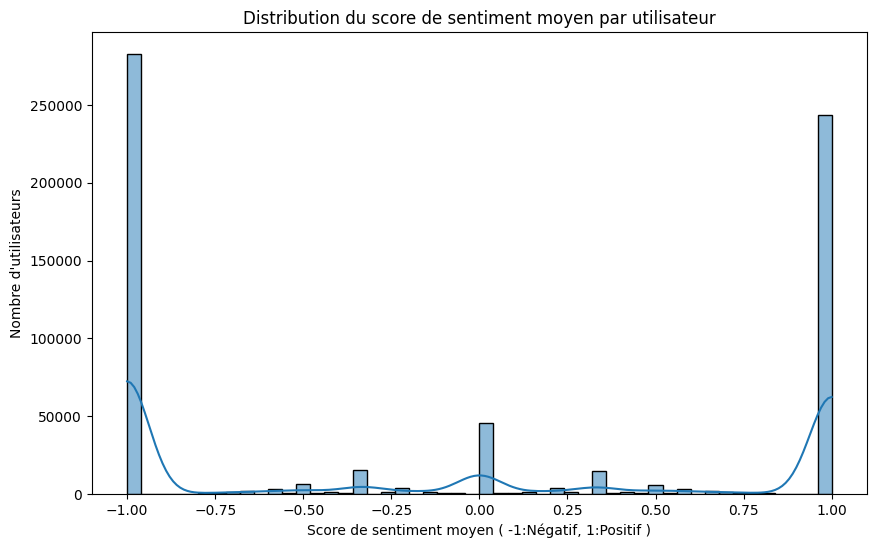


Analyse par utilisateur terminée.

--- Catégorisation des utilisateurs (pour ceux ayant au moins un certain nombre de tweets) ---
sentiment_category
Variable / Mixte           0.527942
Neutre / Équilibré         0.256271
Majoritairement Positif    0.137910
Majoritairement Négatif    0.077877
Name: proportion, dtype: float64


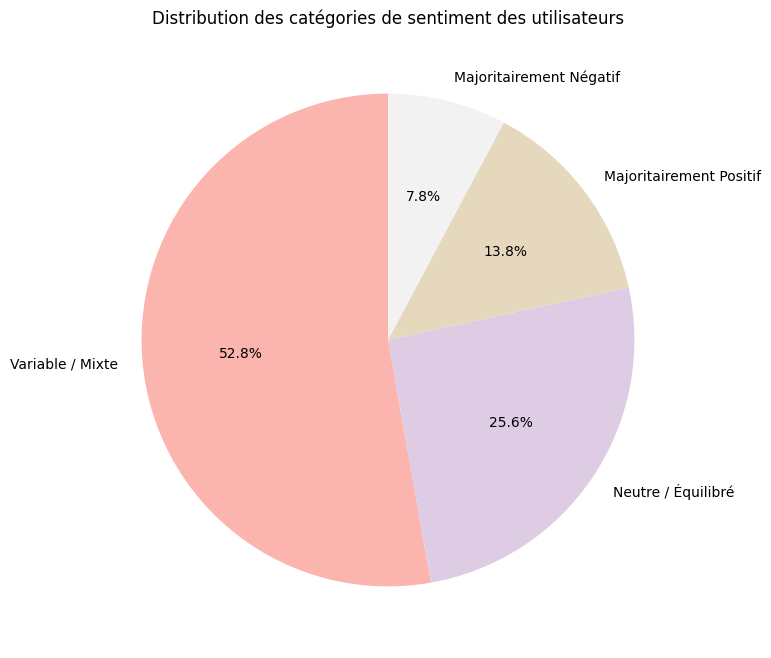


Catégorisation des utilisateurs terminée.


In [49]:
# --- Calcul de la proportion de sentiment par utilisateur ---
user_sentiment_summary = tweets.groupby('user')['sentiment_binary'].agg(
    total_tweets='count',
    positive_tweets=lambda x: (x == 1).sum(),
    negative_tweets=lambda x: (x == 0).sum()
).reset_index()

user_sentiment_summary['positive_ratio'] = user_sentiment_summary['positive_tweets'] / user_sentiment_summary['total_tweets']
user_sentiment_summary['negative_ratio'] = user_sentiment_summary['negative_tweets'] / user_sentiment_summary['total_tweets']

# Calcul de la "moyenne de sentiment" par utilisateur (-1 pour négatif, 1 pour positif)
# Ignorons les neutres puisque nous les avons filtrés
user_sentiment_summary['sentiment_score_avg'] = (user_sentiment_summary['positive_tweets'] - user_sentiment_summary['negative_tweets']) / user_sentiment_summary['total_tweets']

print("\n--- Résumé du sentiment par utilisateur (Top 10 utilisateurs) ---")
print(user_sentiment_summary.sort_values(by='total_tweets', ascending=False).head(10))

# --- Identification des "outliers" (utilisateurs avec un sentiment extrême) ---

# Définir des seuils pour les utilisateurs "très positifs" ou "très négatifs"
# Ces seuils sont arbitraires et peuvent être ajustés
threshold_very_positive = 0.95 # Au moins 95% de tweets positifs
threshold_very_negative = 0.05 # Au plus 5% de tweets positifs (donc au moins 95% négatifs)
min_tweets_for_outlier = 10 # Un utilisateur doit avoir posté un minimum de tweets pour être considéré comme outlier

outlier_users = user_sentiment_summary[
    (user_sentiment_summary['total_tweets'] >= min_tweets_for_outlier) &
    (
        (user_sentiment_summary['positive_ratio'] >= threshold_very_positive) |
        (user_sentiment_summary['positive_ratio'] <= threshold_very_negative)
    )
]

print(f"\n--- Utilisateurs 'Outliers' (>= {min_tweets_for_outlier} tweets, ratio > {threshold_very_positive*100}% positif ou < {threshold_very_negative*100}% positif) ---")
print(outlier_users)

# --- Visualisation de la distribution des sentiments par utilisateur ---
plt.figure(figsize=(10, 6))
sns.histplot(user_sentiment_summary['sentiment_score_avg'], bins=50, kde=True)
plt.title('Distribution du score de sentiment moyen par utilisateur')
plt.xlabel('Score de sentiment moyen ( -1:Négatif, 1:Positif )')
plt.ylabel("Nombre d'utilisateurs")
plt.show()

print("\nAnalyse par utilisateur terminée.")

# --- Aller plus loin : Catégorisation des utilisateurs ---

# Définir des catégories de comportement de sentiment
# Inclure uniquement les utilisateurs ayant un nombre significatif de tweets pour la catégorisation
user_profiles_df = user_sentiment_summary[user_sentiment_summary['total_tweets'] >= min_tweets_for_outlier].copy()

def categorize_user_sentiment(row):
    if row['positive_ratio'] >= 0.9:
        return 'Majoritairement Positif'
    elif row['positive_ratio'] <= 0.1:
        return 'Majoritairement Négatif'
    elif 0.4 <= row['positive_ratio'] <= 0.6:
        return 'Neutre / Équilibré'
    else:
        return 'Variable / Mixte'

user_profiles_df['sentiment_category'] = user_profiles_df.apply(categorize_user_sentiment, axis=1)

print("\n--- Catégorisation des utilisateurs (pour ceux ayant au moins un certain nombre de tweets) ---")
print(user_profiles_df['sentiment_category'].value_counts(normalize=True))

# Visualisation des catégories d'utilisateurs
plt.figure(figsize=(8, 8))
user_profiles_df['sentiment_category'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap='Pastel1'
)
plt.title('Distribution des catégories de sentiment des utilisateurs')
plt.ylabel('') # Supprimer l'étiquette par défaut
plt.show()

print("\nCatégorisation des utilisateurs terminée.")

<h2 style="font-weight: bold;"><u>BoW et TF-IDF</u></h2>

In [23]:
# Appliquer Bag of Words
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(tweets["clean_text"])

# Appliquer TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(tweets["clean_text"])

In [24]:
print(f"Shape BoW : {X_bow.shape}")
print(f"Shape TF-IDF : {X_tfidf.shape}")

# Voir quelques features
print(vectorizer_tfidf.get_feature_names_out()[:10])


Shape BoW : (1600000, 400005)
Shape TF-IDF : (1600000, 400005)
['aa' 'aaa' 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaall' 'aaaaaaaaaaaaaaaaaaaaaaaaaargh'
 'aaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh'
 'aaaaaaaaaaaaaaaaaaaaaaahrg']


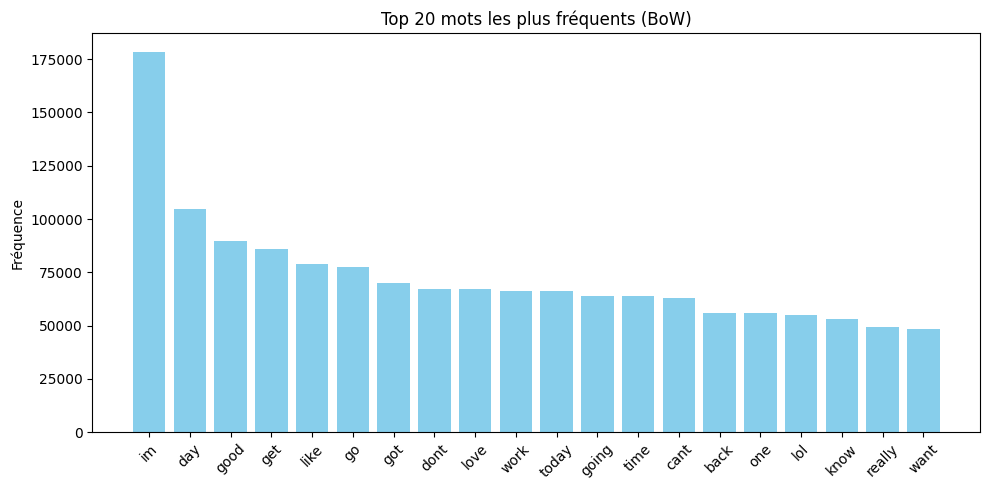

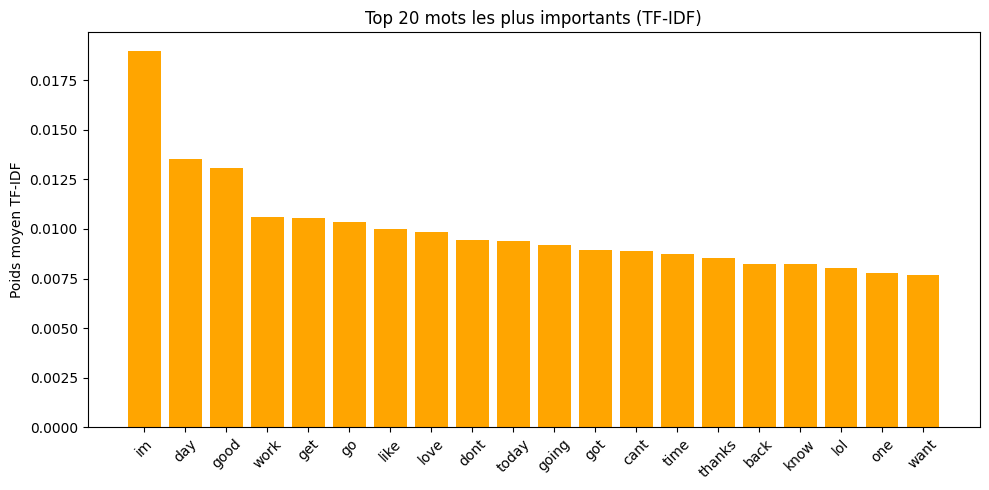

In [25]:
# Nombre de mots à afficher
TOP_N = 20

### ----- 1. Bag of Words : mots les plus fréquents ----- ###
word_counts = np.asarray(X_bow.sum(axis=0)).flatten()
words = vectorizer_bow.get_feature_names_out()
df_bow_freq = pd.DataFrame({'word': words, 'count': word_counts})
df_bow_freq = df_bow_freq.sort_values(by='count', ascending=False).head(TOP_N)

# Affichage
plt.figure(figsize=(10,5))
plt.bar(df_bow_freq['word'], df_bow_freq['count'], color='skyblue')
plt.xticks(rotation=45)
plt.title(f"Top {TOP_N} mots les plus fréquents (BoW)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

### ----- 2. TF-IDF : mots avec le poids moyen le plus élevé ----- ###
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
words_tfidf = vectorizer_tfidf.get_feature_names_out()
df_tfidf_weight = pd.DataFrame({'word': words_tfidf, 'tfidf': tfidf_means})
df_tfidf_weight = df_tfidf_weight.sort_values(by='tfidf', ascending=False).head(TOP_N)

# Affichage
plt.figure(figsize=(10,5))
plt.bar(df_tfidf_weight['word'], df_tfidf_weight['tfidf'], color='orange')
plt.xticks(rotation=45)
plt.title(f"Top {TOP_N} mots les plus importants (TF-IDF)")
plt.ylabel("Poids moyen TF-IDF")
plt.tight_layout()
plt.show()


<h2 style="font-weight: bold;"><u>TF-IDF avec Regression logistique</u></h2>

In [26]:
# Échantillonner 15 000 lignes (stratifié par polarité)
sampled = tweets.groupby("target", group_keys=False).apply(lambda x: x.sample(n=5000, random_state=42))

# Features et labels
X = sampled["clean_text"]
y = sampled["target"]

C:\Users\david\AppData\Local\Temp\ipykernel_74880\368312706.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = tweets.groupby("target", group_keys=False).apply(lambda x: x.sample(n=5000, random_state=42))


In [27]:
# Split Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [28]:
# Pipeline + Cross-validation
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
    ("clf", LogisticRegression(C=1.0, max_iter=1000))
])

# Cross-validation sur train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train,
                            scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"],
                            cv=cv, return_train_score=True)


[WARN] predict_proba non supporté pour val – ROC AUC non loggé.
[WARN] predict_proba non supporté pour test – ROC AUC non loggé.


2025/08/02 14:07:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


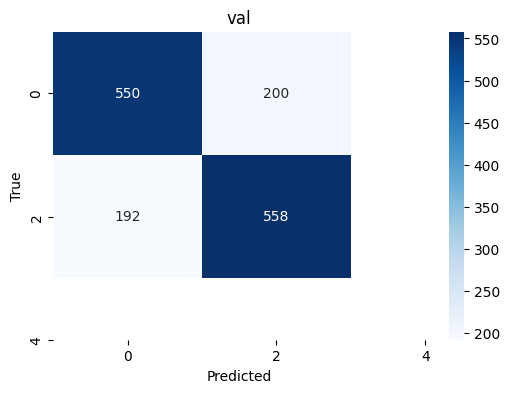

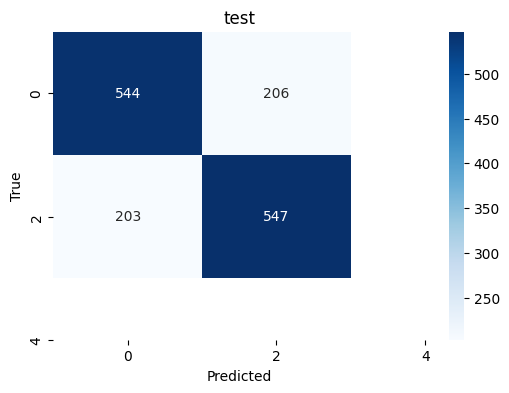

In [29]:
# Entraînement + Validation + Test avec MLflow

# Nom de l'expérience
mlflow.set_experiment("Sentiment_Logistic_Fixed_Hyperparams")  

with mlflow.start_run():
    # Fit pipeline sur train complet
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)

    # Métriques
    def log_metrics(X_true, y_true, y_pred, prefix=""):
        mlflow.log_metric(f"{prefix}_accuracy", accuracy_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_precision", precision_score(y_true, y_pred, average="weighted"))
        mlflow.log_metric(f"{prefix}_recall", recall_score(y_true, y_pred, average="weighted"))
        mlflow.log_metric(f"{prefix}_f1", f1_score(y_true, y_pred, average="weighted"))
    
        # Prédictions probabilistes pour ROC AUC (multiclass)
        try:
            y_proba = pipeline.predict_proba(X_true)
            mlflow.log_metric(f"{prefix}_roc_auc", roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted'))
        except:
            print(f"[WARN] predict_proba non supporté pour {prefix} – ROC AUC non loggé.")

    log_metrics(X_val, y_val, y_val_pred, "val")
    log_metrics(X_test, y_test, y_test_pred, "test")


    # Confusion Matrix
    def plot_conf_matrix(y_true, y_pred, name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,2,4], yticklabels=[0,2,4])
        plt.title(name)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        path = f"conf_matrix_{name}.png"
        plt.savefig(path)
        mlflow.log_artifact(path)

    plot_conf_matrix(y_val, y_val_pred, "val")
    plot_conf_matrix(y_test, y_test_pred, "test")

    # Logs MLflow
    mlflow.log_param("ngram_range", (1,2))
    mlflow.log_param("C", 1.0)
    mlflow.log_param("preprocessing", "lemmatization + stopwords")
    mlflow.log_param("sample_size", len(X))

    mlflow.sklearn.log_model(pipeline, "model")
    joblib.dump(pipeline.named_steps["tfidf"], "tfidf_vectorizer.joblib")
    mlflow.log_artifact("tfidf_vectorizer.joblib")


In [30]:
# Récupérer le dernier run d'une expérience
experiment_name = "Sentiment_Logistic_Fixed_Hyperparams"
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[experiment.experiment_id], order_by=["start_time DESC"])
latest_run = runs[0]

# Extraire les paramètres et métriques
params = latest_run.data.params
metrics = latest_run.data.metrics

# DataFrames séparés
df_params = pd.DataFrame(params.items(), columns=["Parameter", "Value"])
df_metrics = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])

# Affichage côte à côte
html = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="width: 45%;">
        <h3>Paramètres</h3>
        {df_params.to_html(index=False)}
    </div>
    <div style="width: 45%;">
        <h3>Métriques</h3>
        {df_metrics.to_html(index=False)}
    </div>
</div>
"""

display(HTML(html))

Parameter,Value
C,1.0
ngram_range,"(1, 2)"
preprocessing,lemmatization + stopwords
sample_size,10000
Metric,Value
test_accuracy,0.727333
test_f1,0.727332
test_precision,0.727337
test_recall,0.727333
val_accuracy,0.738667


<h2 style="font-weight: bold;"><u>TF-IDF avec optuna et Regression logistique</u></h2>

In [31]:
# Optuna + MLflow
# Optional: réinitialiser le tracking local
mlflow.set_experiment("Sentiment_Logistic_Optuna")

# Séparer X_train (déjà créé avant) pour validation locale
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

def objective(trial):
    # Hyperparamètres à optimiser
    c = trial.suggest_loguniform("C", 1e-3, 10)
    ngram_min = trial.suggest_int("ngram_min", 1, 1)
    ngram_max = trial.suggest_int("ngram_max", 1, 3)
    max_features = trial.suggest_int("max_features", 3000, 15000, step=3000)

    # Définir pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(ngram_min, ngram_max),
            max_features=max_features,
            stop_words="english"
        )),
        ("clf", LogisticRegression(C=c, max_iter=1000))
    ])

    # Cross-validation sur X_train_optuna
    scores = cross_val_score(pipeline, X_train_optuna, y_train_optuna,
                             scoring="f1_weighted", cv=3)
    mean_score = scores.mean()

    # Logging MLflow à chaque essai
    with mlflow.start_run(nested=True):
        mlflow.log_params({
            "C": c,
            "ngram_range": (ngram_min, ngram_max),
            "max_features": max_features
        })
        mlflow.log_metric("mean_f1_cv", mean_score)
    return mean_score

In [32]:
# Lancer l’optimisation Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


[I 2025-08-02 14:07:45,656] A new study created in memory with name: no-name-781f172e-4d40-4956-a6ce-e37e2722911e
C:\Users\david\AppData\Local\Temp\ipykernel_74880\4160087370.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform("C", 1e-3, 10)
[I 2025-08-02 14:07:45,921] Trial 0 finished with value: 0.6885972950885529 and parameters: {'C': 0.030184791429057622, 'ngram_min': 1, 'ngram_max': 1, 'max_features': 3000}. Best is trial 0 with value: 0.6885972950885529.
C:\Users\david\AppData\Local\Temp\ipykernel_74880\4160087370.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform("C", 1e-3, 10)
[I 2025-08-02 14:07:46,64

Best parameters: {'C': 2.4956463656222265, 'ngram_min': 1, 'ngram_max': 3, 'max_features': 9000}
ROC AUC skipped for val: y should be a 1d array, got an array of shape (1500, 2) instead.
ROC AUC skipped for test: y should be a 1d array, got an array of shape (1500, 2) instead.


2025/08/02 14:07:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


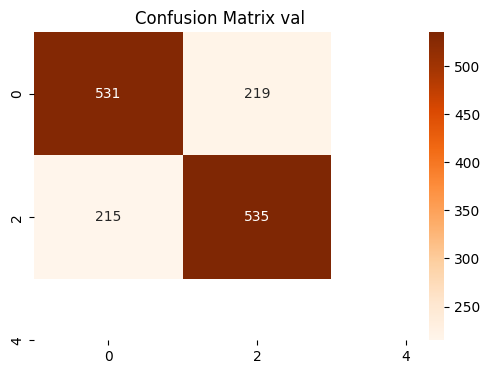

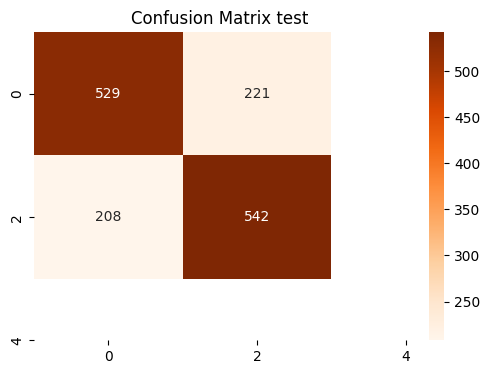

In [33]:
# Évaluer et enregistrer le meilleur modèle
# Récupérer meilleurs paramètres
best_params = study.best_params
print("Best parameters:", best_params)

# Recréer pipeline avec meilleurs params
best_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(best_params["ngram_min"], best_params["ngram_max"]),
        max_features=best_params["max_features"],
        stop_words="english"
    )),
    ("clf", LogisticRegression(C=best_params["C"], max_iter=1000))
])

# Entraîner sur tout le training set
best_pipeline.fit(X_train, y_train)

# Évaluer sur validation et test
y_val_pred = best_pipeline.predict(X_val)
y_test_pred = best_pipeline.predict(X_test)

# Recalcul des métriques
def log_eval_metrics(X_eval, y_true, y_pred, prefix=""):
    mlflow.log_metric(f"{prefix}_accuracy", accuracy_score(y_true, y_pred))
    mlflow.log_metric(f"{prefix}_precision", precision_score(y_true, y_pred, average="weighted"))
    mlflow.log_metric(f"{prefix}_recall", recall_score(y_true, y_pred, average="weighted"))
    mlflow.log_metric(f"{prefix}_f1", f1_score(y_true, y_pred, average="weighted"))
    
    try:
        y_proba = best_pipeline.predict_proba(X_eval)
        mlflow.log_metric(f"{prefix}_roc_auc", roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted"))
    except Exception as e:
        print(f"ROC AUC skipped for {prefix}: {e}")

# Lancer une run MLflow globale
with mlflow.start_run(run_name="Final_Logistic_TFIDF_Optuna"):
    log_eval_metrics(X_val, y_val, y_val_pred, "val")
    log_eval_metrics(X_test, y_test, y_test_pred, "test")
    
    # Confusion matrix
    def save_conf_matrix(y_true, y_pred, name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,2,4], yticklabels=[0,2,4])
        plt.title(f"Confusion Matrix {name}")
        plt.savefig(f"conf_matrix_{name}.png")
        mlflow.log_artifact(f"conf_matrix_{name}.png")

    save_conf_matrix(y_val, y_val_pred, "val")
    save_conf_matrix(y_test, y_test_pred, "test")

    # Log pipeline et vectoriseur
    mlflow.sklearn.log_model(best_pipeline, "best_pipeline")
    joblib.dump(best_pipeline.named_steps["tfidf"], "best_tfidf_vectorizer.joblib")
    mlflow.log_artifact("best_tfidf_vectorizer.joblib")

    # Log paramètres finaux
    mlflow.log_params(best_params)


<h2 style="font-weight: bold;"><u>1A. Word2Vec + Keras</u></h2>

In [34]:
# --- Remap les labels pour binaire : 0 = négatif, 1 = positif
tweets = tweets[tweets["target"].isin([0, 4])]
tweets["target_bin"] = tweets["target"].map({0: 0, 4: 1})
y = tweets["target_bin"]

# --- Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets["clean_text"])
sequences = tokenizer.texts_to_sequences(tweets["clean_text"])
X = pad_sequences(sequences, padding="post")

# --- Word2Vec
tokenized_texts = [t.split() for t in tweets["clean_text"]]
w2v_model = gensim.models.Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# --- Modèle Keras pour classification binaire
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, weights=[embedding_matrix], input_length=X.shape[1], trainable=False),
    LSTM(64),
    Dense(1, activation="sigmoid")  # sigmoid pour binaire
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# --- Tracking MLflow
mlflow.set_experiment("Sentiment_Word2Vec_Keras_Binary")
with mlflow.start_run(run_name="Word2Vec_Binaire"):
    history = model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)
    mlflow.tensorflow.log_model(model, "model")



Epoch 1/5


20000/20000 [==============================] - 340s 17ms/step - loss: 0.4463 - accuracy: 0.7894 - val_loss: 0.6587 - val_accuracy: 0.6167
Epoch 2/5
20000/20000 [==============================] - 332s 17ms/step - loss: 0.4235 - accuracy: 0.8024 - val_loss: 0.5993 - val_accuracy: 0.6566
Epoch 3/5
20000/20000 [==============================] - 330s 16ms/step - loss: 0.4151 - accuracy: 0.8067 - val_loss: 0.6490 - val_accuracy: 0.6935
Epoch 4/5
20000/20000 [==============================] - 323s 16ms/step - loss: 0.4097 - accuracy: 0.8098 - val_loss: 0.6072 - val_accuracy: 0.6964
Epoch 5/5
20000/20000 [==============================] - 332s 17ms/step - loss: 0.4057 - accuracy: 0.8121 - val_loss: 0.6572 - val_accuracy: 0.6719


2025/08/02 14:37:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/08/02 14:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[I 2025-08-02 14:37:29,693] A new study created in memory with name: no-name-8be874cf-140a-4130-857f-8772511b8dcd
[I 2025-08-02 14:37:40,533] Trial 0 finished with value: 0.5260000228881836 and parameters: {'embedding_dim': 50, 'lstm_units': 32, 'dropout': 0.39456760490640586, 'lr': 0.0008686771605706425, 'batch_size': 32}. Best is trial 0 with value: 0.5260000228881836.
[I 2025-08-02 14:37:48,676] Trial 1 finished with value: 0.5176666378974915 and parameters: {'embedding_dim': 50, 'lstm_units': 32, 'dropout': 0.3602565062044989, 'lr': 0.0003049468491914948, 'batch_size': 64}. Best is trial 0 with value: 0.5260000228881836.
[I 2025-08-02 14:38:03,993] Trial 2 finished with value: 0.5270000100135803 and parameters: {'embedding_dim': 100, 'lstm_units': 96, 'dropout': 0.4672053053982437, 'lr': 6.486731519183396e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5270000100135803.
[I 2025-08-02 14:38:20,614] Trial 3 finished with value: 0.5263333320617676 and parameters: {'embedding_dim

✅ Best params: {'embedding_dim': 100, 'lstm_units': 96, 'dropout': 0.4672053053982437, 'lr': 6.486731519183396e-05, 'batch_size': 64}
Epoch 1/5
188/188 [==============================] - 4s 10ms/step - loss: 0.6929 - accuracy: 0.4956
Epoch 2/5
188/188 [==============================] - 2s 10ms/step - loss: 0.6921 - accuracy: 0.5268
Epoch 3/5
188/188 [==============================] - 3s 14ms/step - loss: 0.6918 - accuracy: 0.5326
Epoch 4/5
188/188 [==============================] - 3s 14ms/step - loss: 0.6911 - accuracy: 0.5302
Epoch 5/5
94/94 [==============================] - 1s 5ms/step

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.49      0.50      1497
           1       0.52      0.54      0.53      1503

    accuracy                           0.52      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.52      0.52      0.52      3000



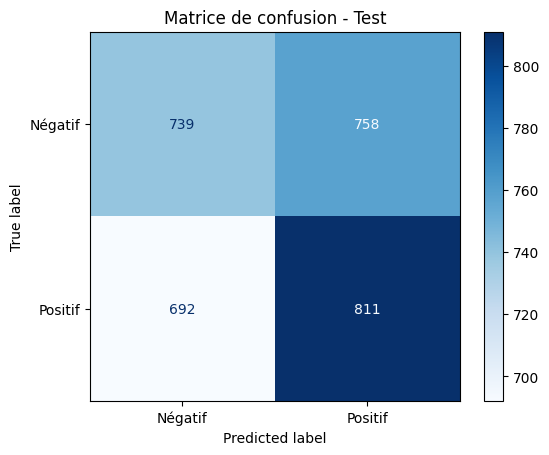

In [35]:
# --- 1. Sous-échantillonnage des 15 000 tweets
tweets_sample = tweets[tweets["target"].isin([0, 4])].sample(n=15000, random_state=42).copy()
tweets_sample["target_bin"] = tweets_sample["target"].map({0: 0, 4: 1})
y = tweets_sample["target_bin"]

# --- 2. Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_sample["clean_text"])
sequences = tokenizer.texts_to_sequences(tweets_sample["clean_text"])
X = pad_sequences(sequences, padding="post")

# --- Préparer les textes tokenisés pour Word2Vec (une fois, hors de l'objectif)
tokenized_texts = [t.split() for t in tweets_sample["clean_text"]]

# --- 4. Split Train / Val / Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# Résultat : 60% train, 20% val, 20% test

# --- 5. Fonction objectif Optuna
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [50, 100, 200])
    lstm_units = trial.suggest_int("lstm_units", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Recréer le modèle Word2Vec avec la dimension d'embedding choisie
    w2v_model = gensim.models.Word2Vec(
        sentences=tokenized_texts,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4
    )

    # Créer la matrice d'embedding adaptée à embedding_dim
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=X.shape[1],
                  trainable=False),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=5,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=2)],
            verbose=0
        )
        val_accuracy = history.history['val_accuracy'][-1]
        mlflow.log_params(trial.params)
        mlflow.log_metric("val_accuracy", val_accuracy)

    return val_accuracy

# --- 6. Lancer Optuna
mlflow.set_experiment("Sentiment_Word2Vec_Keras_optuna")
study = optuna.create_study(direction="maximize")
with mlflow.start_run(run_name="Word2Vec_Binaire_Optuna"):
    study.optimize(objective, n_trials=10)

# --- 7. Réentraîner le meilleur modèle + matrice de confusion
best_params = study.best_trial.params
print("✅ Best params:", best_params)

# Recréer le modèle Word2Vec avec les meilleurs params
w2v_model = gensim.models.Word2Vec(
    sentences=tokenized_texts,
    vector_size=best_params["embedding_dim"],
    window=5,
    min_count=2,
    workers=4
)

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, best_params["embedding_dim"]))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Reconstruire le modèle final
final_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=best_params["embedding_dim"],
              weights=[embedding_matrix],
              input_length=X.shape[1],
              trainable=False),
    LSTM(best_params["lstm_units"]),
    Dropout(best_params["dropout"]),
    Dense(1, activation="sigmoid")
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Entraînement final sur train + val
X_final_train = np.concatenate((X_train, X_val))
y_final_train = pd.concat([y_train, y_val])
final_model.fit(X_final_train, y_final_train, epochs=5, batch_size=best_params["batch_size"], verbose=1)

# Prédictions sur test
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Matrice de confusion
print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Négatif", "Positif"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Test")
plt.show()

[I 2025-08-02 14:40:29,433] A new study created in memory with name: no-name-91daf5ff-a6f6-4ae5-8e7a-720852e581ca


94/94 [==============================] - 1s 3ms/step


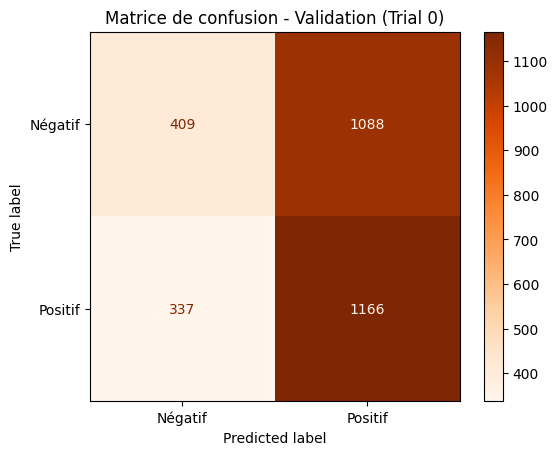

[I 2025-08-02 14:40:42,177] Trial 0 finished with value: 0.5249999761581421 and parameters: {'embedding_dim': 50, 'lstm_units': 32, 'dropout': 0.2355504755718547, 'lr': 0.0004346085788633876, 'batch_size': 32}. Best is trial 0 with value: 0.5249999761581421.


94/94 [==============================] - 1s 5ms/step


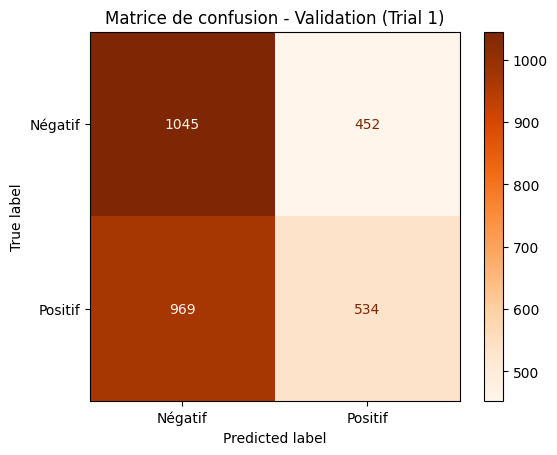

[I 2025-08-02 14:40:57,070] Trial 1 finished with value: 0.5263333320617676 and parameters: {'embedding_dim': 100, 'lstm_units': 96, 'dropout': 0.1920898505465597, 'lr': 1.543700603130365e-05, 'batch_size': 64}. Best is trial 1 with value: 0.5263333320617676.


94/94 [==============================] - 1s 3ms/step


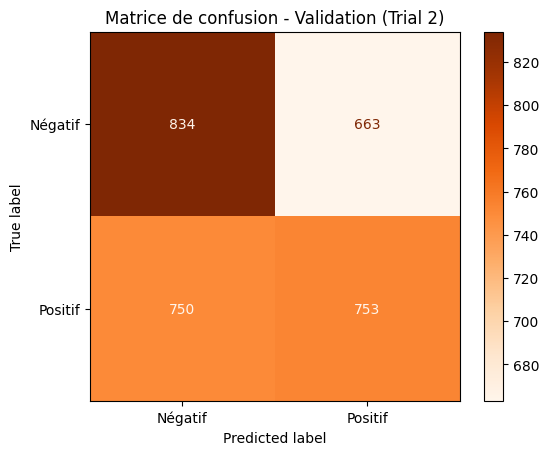

[I 2025-08-02 14:41:12,168] Trial 2 finished with value: 0.5289999842643738 and parameters: {'embedding_dim': 50, 'lstm_units': 64, 'dropout': 0.40739595523115923, 'lr': 6.38986312774578e-05, 'batch_size': 32}. Best is trial 2 with value: 0.5289999842643738.


94/94 [==============================] - 1s 5ms/step


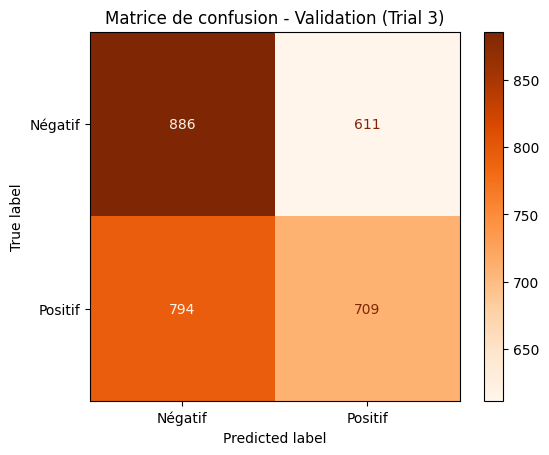

[I 2025-08-02 14:41:34,178] Trial 3 finished with value: 0.5316666960716248 and parameters: {'embedding_dim': 200, 'lstm_units': 64, 'dropout': 0.358534478350083, 'lr': 0.0018469083444629007, 'batch_size': 32}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 4ms/step


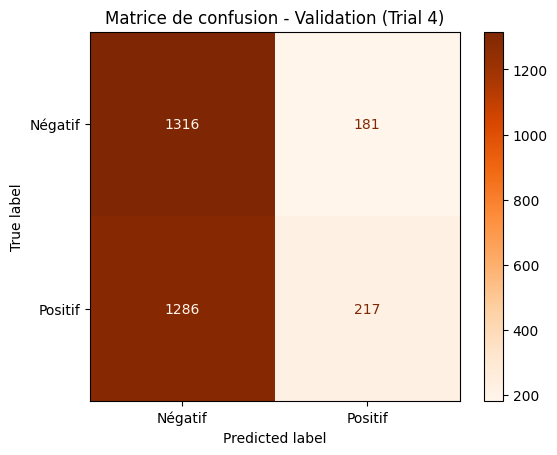

[I 2025-08-02 14:41:48,336] Trial 4 finished with value: 0.5109999775886536 and parameters: {'embedding_dim': 100, 'lstm_units': 64, 'dropout': 0.4338009933218081, 'lr': 1.0444843004416599e-05, 'batch_size': 64}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 5ms/step


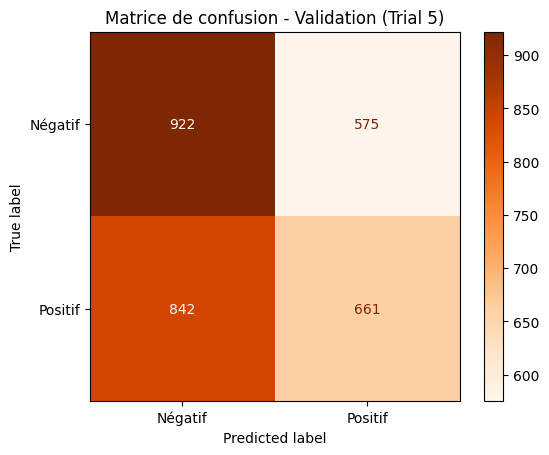

[I 2025-08-02 14:42:06,975] Trial 5 finished with value: 0.5276666879653931 and parameters: {'embedding_dim': 50, 'lstm_units': 96, 'dropout': 0.27903222448908027, 'lr': 2.094033641829207e-05, 'batch_size': 64}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 4ms/step


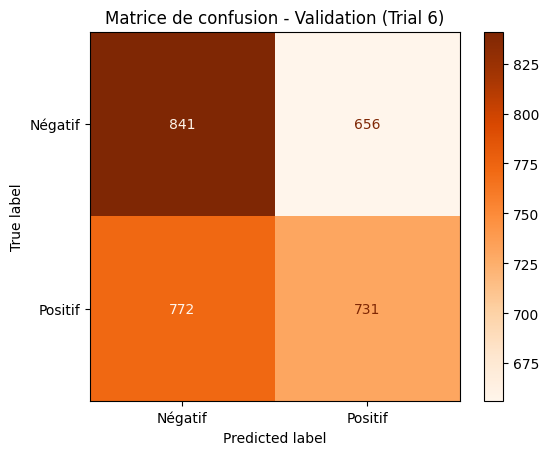

[I 2025-08-02 14:42:22,956] Trial 6 finished with value: 0.5239999890327454 and parameters: {'embedding_dim': 100, 'lstm_units': 32, 'dropout': 0.4355055521724863, 'lr': 0.002696052547131515, 'batch_size': 32}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 4ms/step


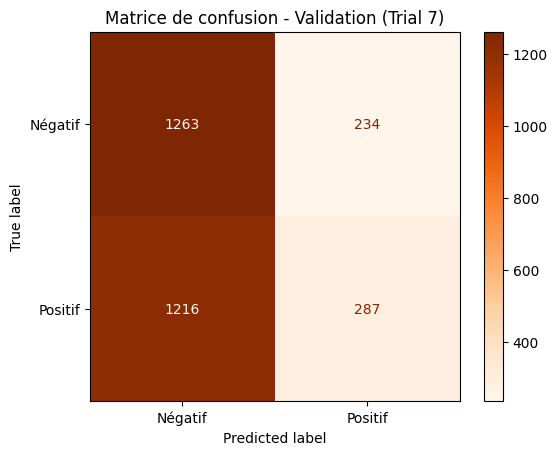

[I 2025-08-02 14:42:37,657] Trial 7 finished with value: 0.5166666507720947 and parameters: {'embedding_dim': 50, 'lstm_units': 64, 'dropout': 0.11360269400630107, 'lr': 1.6820070863340808e-05, 'batch_size': 64}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 7ms/step


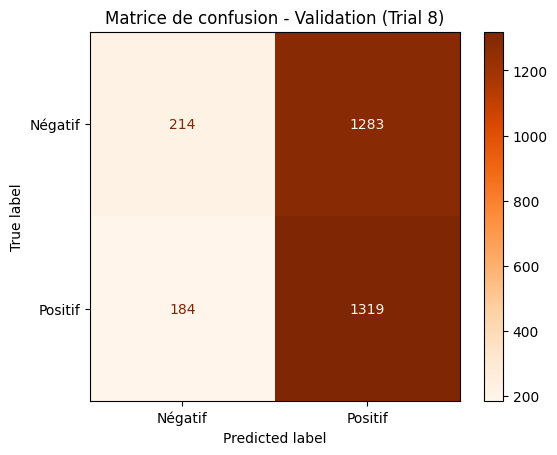

[I 2025-08-02 14:42:55,905] Trial 8 finished with value: 0.5109999775886536 and parameters: {'embedding_dim': 100, 'lstm_units': 128, 'dropout': 0.31739188710350397, 'lr': 0.006771349231416771, 'batch_size': 32}. Best is trial 3 with value: 0.5316666960716248.


94/94 [==============================] - 1s 4ms/step


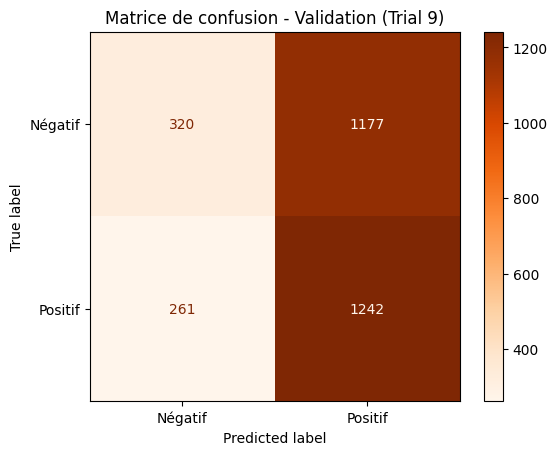

[I 2025-08-02 14:43:06,474] Trial 9 finished with value: 0.5206666588783264 and parameters: {'embedding_dim': 50, 'lstm_units': 96, 'dropout': 0.15268349477950427, 'lr': 0.003259613729595964, 'batch_size': 64}. Best is trial 3 with value: 0.5316666960716248.



✅ Best params: {'embedding_dim': 200, 'lstm_units': 64, 'dropout': 0.358534478350083, 'lr': 0.0018469083444629007, 'batch_size': 32}
Epoch 1/5
375/375 [==============================] - 4s 7ms/step - loss: 0.6931 - accuracy: 0.5148
Epoch 2/5
375/375 [==============================] - 3s 7ms/step - loss: 0.6920 - accuracy: 0.5207
Epoch 3/5
375/375 [==============================] - 3s 9ms/step - loss: 0.6917 - accuracy: 0.5223
Epoch 4/5
375/375 [==============================] - 3s 9ms/step - loss: 0.6917 - accuracy: 0.5231
Epoch 5/5
94/94 [==============================] - 1s 5ms/step

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.47      0.50      1497
           1       0.52      0.57      0.54      1503

    accuracy                           0.52      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.52      0.52      0.52      3000



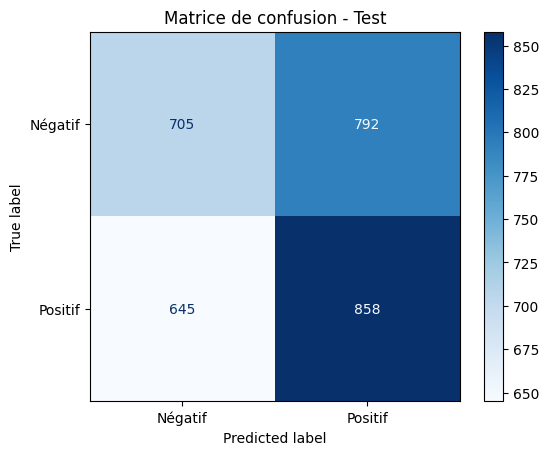

In [36]:
# --- 1. Sous-échantillonnage des 15 000 tweets ---
tweets_sample = tweets[tweets["target"].isin([0, 4])].sample(n=15000, random_state=42).copy()
tweets_sample["target_bin"] = tweets_sample["target"].map({0: 0, 4: 1})
y = tweets_sample["target_bin"]

# --- 2. Tokenisation ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_sample["clean_text"])
sequences = tokenizer.texts_to_sequences(tweets_sample["clean_text"])
X = pad_sequences(sequences, padding="post")

# --- 3. Préparer les textes tokenisés pour Word2Vec ---
tokenized_texts = [t.split() for t in tweets_sample["clean_text"]]

# --- 4. Split Train / Val / Test ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# --- 5. Fonction objectif Optuna avec matrice de confusion sur validation ---
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [50, 100, 200])
    lstm_units = trial.suggest_int("lstm_units", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    w2v_model = gensim.models.Word2Vec(
        sentences=tokenized_texts,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4
    )

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=X.shape[1],
                  trainable=False),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=5,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=2)],
            verbose=0
        )
        val_accuracy = history.history['val_accuracy'][-1]
        mlflow.log_params(trial.params)
        mlflow.log_metric("val_accuracy", val_accuracy)

        # --- Matrice de confusion sur Validation ---
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)
        cm_val = confusion_matrix(y_val, y_val_pred)
        disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Négatif", "Positif"])
        disp_val.plot(cmap="Oranges")
        plt.title(f"Matrice de confusion - Validation (Trial {trial.number})")
        plt.show()

    return val_accuracy

# --- 6. Lancer Optuna ---
mlflow.set_experiment("Sentiment_Word2Vec_Keras_optuna")
study = optuna.create_study(direction="maximize")
with mlflow.start_run(run_name="Word2Vec_Binaire_Optuna"):
    study.optimize(objective, n_trials=10)

# --- 7. Réentraîner le meilleur modèle + matrice de confusion sur Test ---
best_params = study.best_trial.params
print("\n✅ Best params:", best_params)

w2v_model = gensim.models.Word2Vec(
    sentences=tokenized_texts,
    vector_size=best_params["embedding_dim"],
    window=5,
    min_count=2,
    workers=4
)

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, best_params["embedding_dim"]))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

final_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=best_params["embedding_dim"],
              weights=[embedding_matrix],
              input_length=X.shape[1],
              trainable=False),
    LSTM(best_params["lstm_units"]),
    Dropout(best_params["dropout"]),
    Dense(1, activation="sigmoid")
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

X_final_train = np.concatenate((X_train, X_val))
y_final_train = pd.concat([y_train, y_val])
final_model.fit(X_final_train, y_final_train, epochs=5, batch_size=best_params["batch_size"], verbose=1)

# --- Prédictions sur test ---
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Négatif", "Positif"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Test")
plt.show()

[I 2025-08-02 14:43:27,191] A new study created in memory with name: no-name-718ecc8e-1e40-49b1-8b09-5a090d956dbe
[I 2025-08-02 14:43:45,283] Trial 0 finished with value: 0.5143333077430725 and parameters: {'embedding_dim': 200, 'lstm_units': 64, 'dropout': 0.15672443526279423, 'lr': 0.006298685695233823, 'batch_size': 32}. Best is trial 0 with value: 0.5143333077430725.
[I 2025-08-02 14:44:06,618] Trial 1 finished with value: 0.5163333415985107 and parameters: {'embedding_dim': 200, 'lstm_units': 128, 'dropout': 0.2760101139095173, 'lr': 0.0004782536071315539, 'batch_size': 32}. Best is trial 1 with value: 0.5163333415985107.
[I 2025-08-02 14:44:25,663] Trial 2 finished with value: 0.5306666493415833 and parameters: {'embedding_dim': 50, 'lstm_units': 64, 'dropout': 0.39546841848793557, 'lr': 0.0018927083916571526, 'batch_size': 32}. Best is trial 2 with value: 0.5306666493415833.
[I 2025-08-02 14:44:36,889] Trial 3 finished with value: 0.5143333077430725 and parameters: {'embedding_d


✅ Best params: {'embedding_dim': 100, 'lstm_units': 96, 'dropout': 0.3828082583140233, 'lr': 0.0005806369734554543, 'batch_size': 32}
Epoch 1/5
375/375 [==============================] - 5s 8ms/step - loss: 0.6925 - accuracy: 0.5203
Epoch 2/5
375/375 [==============================] - 3s 9ms/step - loss: 0.6918 - accuracy: 0.5242
Epoch 3/5
375/375 [==============================] - 4s 11ms/step - loss: 0.6912 - accuracy: 0.5252
Epoch 4/5
375/375 [==============================] - 4s 10ms/step - loss: 0.6915 - accuracy: 0.5261
Epoch 5/5
94/94 [==============================] - 1s 6ms/step

📊 Classification report (VALIDATION):
               precision    recall  f1-score   support

           0       0.55      0.25      0.35      1497
           1       0.52      0.79      0.63      1503

    accuracy                           0.52      3000
   macro avg       0.53      0.52      0.49      3000
weighted avg       0.53      0.52      0.49      3000



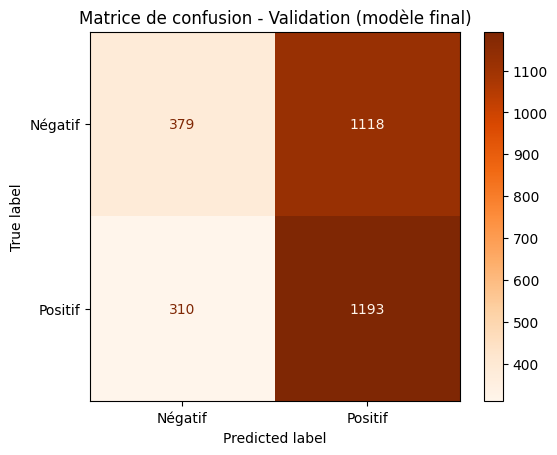

94/94 [==============================] - 1s 5ms/step

📊 Classification report (TEST):
               precision    recall  f1-score   support

           0       0.55      0.25      0.35      1497
           1       0.52      0.79      0.63      1503

    accuracy                           0.52      3000
   macro avg       0.53      0.52      0.49      3000
weighted avg       0.53      0.52      0.49      3000



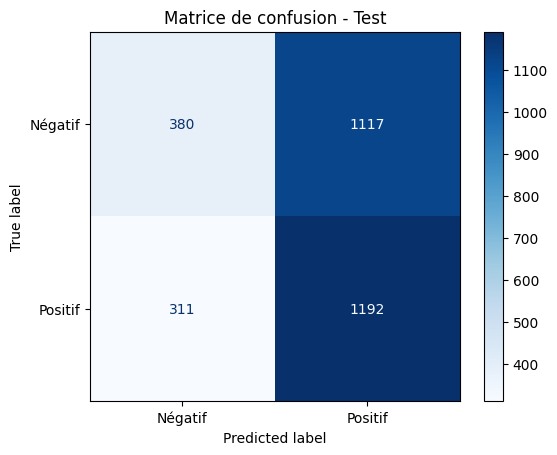

In [37]:
# --- 1. Sous-échantillonnage des 15 000 tweets ---
tweets_sample = tweets[tweets["target"].isin([0, 4])].sample(n=15000, random_state=42).copy()
tweets_sample["target_bin"] = tweets_sample["target"].map({0: 0, 4: 1})
y = tweets_sample["target_bin"]

# --- 2. Tokenisation ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_sample["clean_text"])
sequences = tokenizer.texts_to_sequences(tweets_sample["clean_text"])
X = pad_sequences(sequences, padding="post")

# --- 3. Préparer les textes tokenisés pour Word2Vec ---
tokenized_texts = [t.split() for t in tweets_sample["clean_text"]]

# --- 4. Split Train / Val / Test ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# --- 5. Fonction objectif Optuna (sans matrice de confusion) ---
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [50, 100, 200])
    lstm_units = trial.suggest_int("lstm_units", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    w2v_model = gensim.models.Word2Vec(
        sentences=tokenized_texts,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4
    )

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=X.shape[1],
                  trainable=False),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=5,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=2)],
            verbose=0
        )
        val_accuracy = history.history['val_accuracy'][-1]
        mlflow.log_params(trial.params)
        mlflow.log_metric("val_accuracy", val_accuracy)

    return val_accuracy

# --- 6. Lancer Optuna ---
mlflow.set_experiment("Sentiment_Word2Vec_Keras_optuna")
study = optuna.create_study(direction="maximize")
with mlflow.start_run(run_name="Word2Vec_Binaire_Optuna"):
    study.optimize(objective, n_trials=10)

# --- 7. Réentraîner le meilleur modèle + matrices de confusion sur VALIDATION & TEST ---
best_params = study.best_trial.params
print("\n✅ Best params:", best_params)

# Entraînement Word2Vec final
w2v_model = gensim.models.Word2Vec(
    sentences=tokenized_texts,
    vector_size=best_params["embedding_dim"],
    window=5,
    min_count=2,
    workers=4
)

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, best_params["embedding_dim"]))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Création du modèle final
final_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=best_params["embedding_dim"],
              weights=[embedding_matrix],
              input_length=X.shape[1],
              trainable=False),
    LSTM(best_params["lstm_units"]),
    Dropout(best_params["dropout"]),
    Dense(1, activation="sigmoid")
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Entraînement sur TRAIN + VAL
X_final_train = np.concatenate((X_train, X_val))
y_final_train = pd.concat([y_train, y_val])
final_model.fit(X_final_train, y_final_train, epochs=5, batch_size=best_params["batch_size"], verbose=1)

# --- MATRICE VALIDATION (sur ancien X_val, même si inclus dans l'entraînement final) ---
y_val_pred_prob_final = final_model.predict(X_val)
y_val_pred_final = (y_val_pred_prob_final > 0.5).astype(int)

print("\n📊 Classification report (VALIDATION):\n", classification_report(y_val, y_val_pred_final))
cm_val_final = confusion_matrix(y_val, y_val_pred_final)
disp_val_final = ConfusionMatrixDisplay(confusion_matrix=cm_val_final, display_labels=["Négatif", "Positif"])
disp_val_final.plot(cmap="Oranges")
plt.title("Matrice de confusion - Validation (modèle final)")
plt.show()

# --- MATRICE TEST ---
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📊 Classification report (TEST):\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Négatif", "Positif"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Test")
plt.show()


<h2 style="font-weight: bold;"><u>USE + TensorFlow-Keras</u></h2>

Epoch 1/10
329/329 [==============================] - 14s 28ms/step - loss: 0.6551 - accuracy: 0.6968 - val_loss: 0.6094 - val_accuracy: 0.7587
Epoch 2/10
329/329 [==============================] - 7s 22ms/step - loss: 0.5634 - accuracy: 0.7631 - val_loss: 0.5245 - val_accuracy: 0.7640
Epoch 3/10
329/329 [==============================] - 7s 22ms/step - loss: 0.5057 - accuracy: 0.7681 - val_loss: 0.4906 - val_accuracy: 0.7671
Epoch 4/10
329/329 [==============================] - 7s 23ms/step - loss: 0.4859 - accuracy: 0.7715 - val_loss: 0.4776 - val_accuracy: 0.7711
Epoch 5/10
329/329 [==============================] - 7s 23ms/step - loss: 0.4763 - accuracy: 0.7757 - val_loss: 0.4721 - val_accuracy: 0.7729
Epoch 6/10
329/329 [==============================] - 8s 23ms/step - loss: 0.4708 - accuracy: 0.7774 - val_loss: 0.4694 - val_accuracy: 0.7747
Epoch 7/10
329/329 [==============================] - 7s 22ms/step - loss: 0.4681 - accuracy: 0.7776 - val_loss: 0.4677 - val_accuracy: 0.773

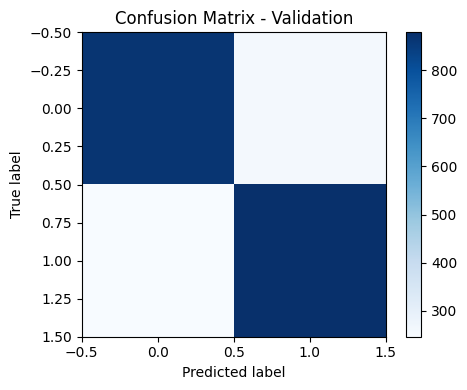


--- Test set ---
71/71 [==============================] - 1s 13ms/step

Classification report on Test:
              precision    recall  f1-score   support

           0     0.7687    0.7680    0.7683      1125
           1     0.7682    0.7689    0.7685      1125

    accuracy                         0.7684      2250
   macro avg     0.7684    0.7684    0.7684      2250
weighted avg     0.7684    0.7684    0.7684      2250

F1-score: 0.7685
ROC AUC: 0.8549
Confusion matrix:
[[864 261]
 [260 865]]


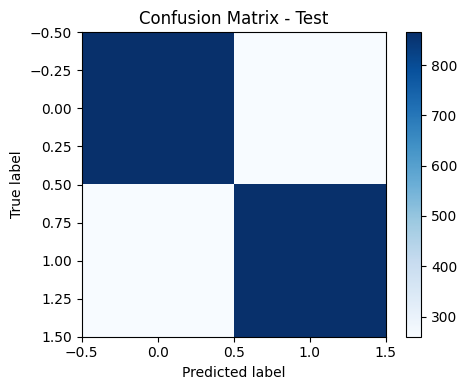

2025/08/02 19:01:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/08/02 19:03:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\david\AppData\Local\Temp\tmpgf3czfst\model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/08/02 19:03:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SentimentAnalysisModel' already exists. Creating a new version of this model...
2025/08/02 19:03:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to

🏃 View run USE_Model at: http://127.0.0.1:5000/#/experiments/284053414159246924/runs/a6aabd02bdf44fac8cd2562dcd024ad0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/284053414159246924


In [52]:
# Assurez-vous que cette URI est la même que celle où vous avez lancé 'mlflow ui'
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000" # Adaptez si votre adresse est différente
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # Ceci est aussi une bonne pratique

# 1. Charger et préparer les données originales ---
column_names = ["target", "ids", "date", "flag", "user", "text"]
tweets = pd.read_csv(
    "data/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    names=column_names,
    header=None
)

# On garde uniquement les classes 0 (négatif) et 4 (positif)
tweets = tweets[tweets["target"].isin([0, 4])]

# On échantillonne 7500 positifs et 7500 négatifs pour équilibrer
sample_neg = tweets[tweets["target"] == 0].sample(n=7500, random_state=42)
sample_pos = tweets[tweets["target"] == 4].sample(n=7500, random_state=42)
df = pd.concat([sample_neg, sample_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

# Encodage binaire : 0 (négatif), 1 (positif)
df["target_bin"] = df["target"].map({0: 0, 4: 1})

# --- 2. Séparation train / validation / test ---
texts = df["text"].values
labels = df["target_bin"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- 3. Chargement du modèle Universal Sentence Encoder ---
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

# --- 4. Construction du modèle Keras ---
model = tf.keras.Sequential([
    use_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 5. Callback EarlyStopping ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# --- 6. Fonction d'évaluation et de visualisation ---
def predict_and_report(model, X, y, split_name="dataset", log_with_mlflow=False):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"\nClassification report on {split_name}:")
    print(classification_report(y, y_pred, digits=4))
    print(f"F1-score: {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_pred_proba):.4f}")

    cm = confusion_matrix(y, y_pred)
    print(f"Confusion matrix:\n{cm}")
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {split_name}")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()

    fig_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
    plt.savefig(fig_path)
    plt.show()

    if log_with_mlflow:
        mlflow.log_artifact(fig_path, artifact_path=f"conf_matrix_{split_name.lower()}")
        mlflow.log_metrics({
            f"{split_name}_f1": f1_score(y, y_pred),
            f"{split_name}_roc_auc": roc_auc_score(y, y_pred_proba),
            f"{split_name}_accuracy": accuracy_score(y, y_pred)
        })

# --- 7. Entraînement avec MLflow ---
mlflow.set_experiment("Sentiment_USE_Keras")

with mlflow.start_run(run_name="USE_Model"):
    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Log des hyperparamètres
    mlflow.log_params({
        "embedding": "USE",
        "hidden_units": 256,
        "dropout": 0.3,
        "learning_rate": 1e-4,
        "batch_size": 32,
        "epochs": len(history.history["loss"])
    })

    # Évaluation sur validation + test avec log
    print("\n--- Validation set ---")
    predict_and_report(model, X_val, y_val, "Validation", log_with_mlflow=True)

    print("\n--- Test set ---")
    predict_and_report(model, X_test, y_test, "Test", log_with_mlflow=True)

    # Log du modèle
    mlflow.tensorflow.log_model(model, artifact_path="model", registered_model_name="SentimentAnalysisModel")

Epoch 1/10
329/329 [==============================] - 7s 15ms/step - loss: 0.6560 - accuracy: 0.6987 - val_loss: 0.6100 - val_accuracy: 0.7560
Epoch 2/10
329/329 [==============================] - 4s 11ms/step - loss: 0.5643 - accuracy: 0.7603 - val_loss: 0.5253 - val_accuracy: 0.7662
Epoch 3/10
329/329 [==============================] - 4s 11ms/step - loss: 0.5066 - accuracy: 0.7671 - val_loss: 0.4903 - val_accuracy: 0.7684
Epoch 4/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4852 - accuracy: 0.7737 - val_loss: 0.4777 - val_accuracy: 0.7716
Epoch 5/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4753 - accuracy: 0.7750 - val_loss: 0.4725 - val_accuracy: 0.7733
Epoch 6/10
329/329 [==============================] - 4s 11ms/step - loss: 0.4706 - accuracy: 0.7797 - val_loss: 0.4688 - val_accuracy: 0.7742
Epoch 7/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4670 - accuracy: 0.7796 - val_loss: 0.4677 - val_accuracy: 0.7747

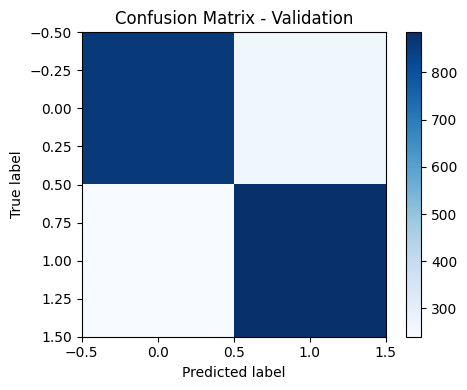


--- Test set ---
71/71 [==============================] - 0s 6ms/step

Classification report on Test:
              precision    recall  f1-score   support

           0     0.7715    0.7653    0.7684      1125
           1     0.7672    0.7733    0.7703      1125

    accuracy                         0.7693      2250
   macro avg     0.7694    0.7693    0.7693      2250
weighted avg     0.7694    0.7693    0.7693      2250

F1-score: 0.7703
ROC AUC: 0.8545
Confusion matrix:
[[861 264]
 [255 870]]


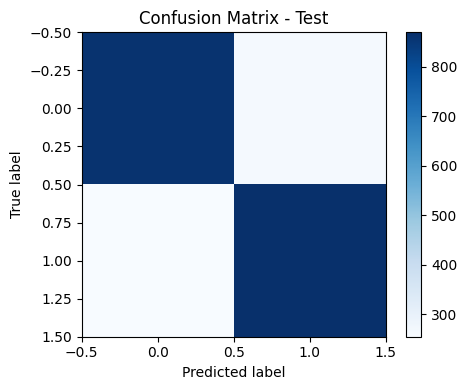

2025/08/03 16:15:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/08/03 16:15:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\david\AppData\Local\Temp\tmp71_0iuft\model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/08/03 16:15:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SentimentAnalysisModel' already exists. Creating a new version of this model...
2025/08/03 16:15:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to

🏃 View run USE_Model at: http://127.0.0.1:5000/#/experiments/284053414159246924/runs/a2d8e967dc814f8e801126f0d50f3573
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/284053414159246924


In [53]:
# Assurez-vous que cette URI est la même que celle où vous avez lancé 'mlflow ui'
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000" # Adaptez si votre adresse est différente
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # Ceci est aussi une bonne pratique

# 1. Charger et préparer les données originales ---
column_names = ["target", "ids", "date", "flag", "user", "text"]
tweets = pd.read_csv(
    "data/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    names=column_names,
    header=None
)

# On garde uniquement les classes 0 (négatif) et 4 (positif)
tweets = tweets[tweets["target"].isin([0, 4])]

# On échantillonne 7500 positifs et 7500 négatifs pour équilibrer
sample_neg = tweets[tweets["target"] == 0].sample(n=7500, random_state=42)
sample_pos = tweets[tweets["target"] == 4].sample(n=7500, random_state=42)
df = pd.concat([sample_neg, sample_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

# Encodage binaire : 0 (négatif), 1 (positif)
df["target_bin"] = df["target"].map({0: 0, 4: 1})

# --- 2. Séparation train / validation / test ---
texts = df["text"].values
labels = df["target_bin"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- 3. Chargement du modèle Universal Sentence Encoder ---
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

# --- 4. Construction du modèle Keras ---
model = tf.keras.Sequential([
    use_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 5. Callback EarlyStopping ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# --- 6. Fonction d'évaluation et de visualisation ---
def predict_and_report(model, X, y, split_name="dataset", log_with_mlflow=False):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"\nClassification report on {split_name}:")
    print(classification_report(y, y_pred, digits=4))
    print(f"F1-score: {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_pred_proba):.4f}")

    cm = confusion_matrix(y, y_pred)
    print(f"Confusion matrix:\n{cm}")
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {split_name}")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()

    fig_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
    plt.savefig(fig_path)
    plt.show()

    if log_with_mlflow:
        mlflow.log_artifact(fig_path, artifact_path=f"conf_matrix_{split_name.lower()}")
        mlflow.log_metrics({
            f"{split_name}_f1": f1_score(y, y_pred),
            f"{split_name}_roc_auc": roc_auc_score(y, y_pred_proba),
            f"{split_name}_accuracy": accuracy_score(y, y_pred)
        })

# --- 7. Entraînement avec MLflow ---
mlflow.set_experiment("Sentiment_USE_Keras")

with mlflow.start_run(run_name="USE_Model"):
    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Log des hyperparamètres
    mlflow.log_params({
        "embedding": "USE",
        "hidden_units": 256,
        "dropout": 0.3,
        "learning_rate": 1e-4,
        "batch_size": 32,
        "epochs": len(history.history["loss"])
    })

    # Évaluation sur validation + test avec log
    print("\n--- Validation set ---")
    predict_and_report(model, X_val, y_val, "Validation", log_with_mlflow=True)

    print("\n--- Test set ---")
    predict_and_report(model, X_test, y_test, "Test", log_with_mlflow=True)

    # Log du modèle
    mlflow.tensorflow.log_model(model, artifact_path="model", registered_model_name="SentimentAnalysisModel")

In [54]:
# --- Configuration MLflow ---
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# --- Chargement et préparation des données ---
column_names = ["target", "ids", "date", "flag", "user", "text"]
tweets = pd.read_csv(
    "data/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    names=column_names,
    header=None
)

tweets = tweets[tweets["target"].isin([0, 4])]

sample_neg = tweets[tweets["target"] == 0].sample(n=7500, random_state=42)
sample_pos = tweets[tweets["target"] == 4].sample(n=7500, random_state=42)
df = pd.concat([sample_neg, sample_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

df["target_bin"] = df["target"].map({0: 0, 4: 1})

texts = df["text"].values
labels = df["target_bin"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- Chargement du modèle USE ---
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

# --- Construction du modèle ---
model = tf.keras.Sequential([
    use_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# --- Fonction d'évaluation et log ---
def predict_and_report(model, X, y, split_name="dataset", log_with_mlflow=False):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"\nClassification report on {split_name}:")
    print(classification_report(y, y_pred, digits=4))
    print(f"F1-score: {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_pred_proba):.4f}")

    cm = confusion_matrix(y, y_pred)
    print(f"Confusion matrix:\n{cm}")
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {split_name}")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()

    fig_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
    plt.savefig(fig_path)
    plt.close()  # Important !

    if log_with_mlflow:
        mlflow.log_artifact(fig_path, artifact_path=f"conf_matrix_{split_name.lower()}")
        mlflow.log_metrics({
            f"{split_name}_f1": f1_score(y, y_pred),
            f"{split_name}_roc_auc": roc_auc_score(y, y_pred_proba),
            f"{split_name}_accuracy": accuracy_score(y, y_pred)
        })

# --- Entraînement + logging MLflow ---
mlflow.set_experiment("Sentiment_USE_Keras")

with mlflow.start_run(run_name="USE_Model"):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    mlflow.log_params({
        "embedding": "USE",
        "hidden_units": 256,
        "dropout": 0.3,
        "learning_rate": 1e-4,
        "batch_size": 32,
        "epochs": len(history.history["loss"])
    })

    print("\n--- Validation set ---")
    predict_and_report(model, X_val, y_val, "Validation", log_with_mlflow=True)

    print("\n--- Test set ---")
    predict_and_report(model, X_test, y_test, "Test", log_with_mlflow=True)

    # Ici on logue le modèle complet Keras
    mlflow.keras.log_model(model, artifact_path="model", registered_model_name="SentimentAnalysisModel")

Epoch 1/10
329/329 [==============================] - 7s 14ms/step - loss: 0.6548 - accuracy: 0.7009 - val_loss: 0.6073 - val_accuracy: 0.7507
Epoch 2/10
329/329 [==============================] - 4s 11ms/step - loss: 0.5632 - accuracy: 0.7605 - val_loss: 0.5237 - val_accuracy: 0.7613
Epoch 3/10
329/329 [==============================] - 4s 11ms/step - loss: 0.5056 - accuracy: 0.7683 - val_loss: 0.4895 - val_accuracy: 0.7684
Epoch 4/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4856 - accuracy: 0.7698 - val_loss: 0.4767 - val_accuracy: 0.7711
Epoch 5/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4758 - accuracy: 0.7759 - val_loss: 0.4717 - val_accuracy: 0.7724
Epoch 6/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4713 - accuracy: 0.7750 - val_loss: 0.4688 - val_accuracy: 0.7729
Epoch 7/10
329/329 [==============================] - 3s 10ms/step - loss: 0.4680 - accuracy: 0.7796 - val_loss: 0.4670 - val_accuracy: 0.7738

2025/08/03 16:31:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/03 16:31:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\david\AppData\Local\Temp\tmpua7pkn4_\model, flavor: keras). Fall back to return ['keras==3.11.1']. Set logging level to DEBUG to see the full traceback. 
2025/08/03 16:31:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SentimentAnalysisModel' already exists. Creating a new version of this model...
2025/08/03 16:31:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SentimentAnalysisModel, version 4
Created version '4' of model 'SentimentAnalysisModel'.


🏃 View run USE_Model at: http://127.0.0.1:5000/#/experiments/284053414159246924/runs/ef9449d92218448fa38d23b2ba665b52
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/284053414159246924


<h2 style="font-weight: bold;"><u>2A. BERT + Hugging Face</u></h2>